# 072523 - Semi-supervised learning for classification with clustering-assisted labelling.

## Background

Semi-supervised learning is a type of machine learning where only some of the data is labeled and the goal is to use the labeled data to make predictions on the unlabeled data. Clustering-assisted labeling is a technique used in semi-supervised learning where clustering is used to group similar data points together and then assign labels to these groups.

The basic idea behind clustering-assisted labeling is to use clustering to group similar data points together, and then use the labeled data to assign labels to the clusters. Once the clusters have been labeled, the labels can be propagated to the unlabeled data points in the same cluster.

The advantage of using clustering-assisted labeling is that it allows us to make use of the structure in the data to generate labels for the unlabeled data. This can be particularly useful in cases where labeling the data manually is time-consuming or expensive.

In the context of algo trading, clustering-assisted labeling can be used to create labels for financial data, such as stock prices or exchange rates. The clustering algorithm can be used to group similar data points together based on their attributes, such as volatility or volume. The labeled data can then be used to train a machine learning algorithm to make predictions on the unlabeled data.

Done:
- [x] Re-done the whole backtesting workflow. using Fintech code. 
- [x] Calculate Sortino and Sharpe Ratio 

To-Do:
- [ ] Re-do the AIML part 
- [ ] Deploy for paper-trading

Next Project: 
- [ ] Use DCA method for selling 30% of capital everytime we earned +50%
- [ ] Use FNG or CBBI has a way to invest: while FNG<90%, all-in crypto using DCMA. Is FNG above 90% convert all to USD (or stock)

---
## 0. Imports

In [121]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('/Users/adriencaudron/BOOTCAMP/Playground/AlphaJet2.0/ALGOTRADING_Research/functions_library')

from functions import ROC, model_selection, Backtesting

#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

# Visualization libraries
import matplotlib.pyplot as plt
import hvplot.pandas



seed = 42

---
## 1. Data Loading

--- 
Get latest FNG data 


In [122]:
import requests

url = "https://api.alternative.me/fng/?limit=0&format=json"
response = requests.get(url)

if response.status_code == 200:
    with open("fear_and_greed_index.json", "wb") as file:
        file.write(response.content)
    print("Fear & Greed JSON data downloaded successfully.")
else:
    print("Failed to download FNG data.")

Fear & Greed JSON data downloaded successfully.


In [123]:
import json 

fng_json = Path("fear_and_greed_index.json")

# Read the JSON data from the file
with open('fear_and_greed_index.json') as file:
    data = json.load(file)

# Extract the "data" section from the JSON
data = data['data']

# Convert the data to a DataFrame
fng_df = pd.DataFrame(data)

In [124]:
# Convert the "timestamp" column to datetime format
fng_df['timestamp'] = pd.to_datetime(fng_df['timestamp'], unit='s')

# Set the "timestamp" column as the index
fng_df.set_index('timestamp', inplace=True)

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.


In [125]:
fng_df.drop("time_until_update",axis=1,inplace=True)

In [126]:
fng_df.head()

value value_classification
timestamp                            
2023-08-28    39                 Fear
2023-08-27    38                 Fear
2023-08-26    38                 Fear
2023-08-25    39                 Fear
2023-08-24    41                 Fear

Read the CSV file into Pandas DataFrame

In [127]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../Get_Crypto_Data/ETHUSDT-1h-data.csv"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

trading_df = trading_df.drop(["close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis =1)

# Review the DataFrame
trading_df.head()

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


open    high    low   close     volume
timestamp                                                    
2017-08-17 04:00:00  301.13  302.57  298.0  301.61  125.66877
2017-08-17 05:00:00  301.61  303.28  300.0  303.10  377.67246
2017-08-17 06:00:00  302.40  304.44  301.9  302.68  303.86672
2017-08-17 07:00:00  302.68  307.96  302.6  307.96  754.74510
2017-08-17 08:00:00  307.95  309.97  307.0  308.62  150.75029

In [128]:
# drop duplicate index label
trading_df = trading_df[~trading_df.index.duplicated(keep='first')]

In [129]:
trading_df.tail()

open     high      low    close      volume
timestamp                                                          
2023-08-28 14:00:00  1649.16  1653.29  1646.85  1651.00   9375.7916
2023-08-28 15:00:00  1650.99  1655.14  1642.86  1648.91  12354.7222
2023-08-28 16:00:00  1648.92  1652.49  1647.61  1651.01  10082.9669
2023-08-28 17:00:00  1651.01  1654.96  1648.76  1649.71   5983.4624
2023-08-28 18:00:00  1649.71  1650.44  1646.63  1648.05    976.5865

Add a daily return values column to the DataFrame

In [130]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["daily_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

open    high     low   close     volume  daily_returns
timestamp                                                                    
2017-08-17 05:00:00  301.61  303.28  300.00  303.10  377.67246       0.004940
2017-08-17 06:00:00  302.40  304.44  301.90  302.68  303.86672      -0.001386
2017-08-17 07:00:00  302.68  307.96  302.60  307.96  754.74510       0.017444
2017-08-17 08:00:00  307.95  309.97  307.00  308.62  150.75029       0.002143
2017-08-17 09:00:00  308.62  312.00  308.62  310.00  469.27879       0.004472

open     high      low    close      volume  \
timestamp                                                             
2023-08-28 14:00:00  1649.16  1653.29  1646.85  1651.00   9375.7916   
2023-08-28 15:00:00  1650.99  1655.14  1642.86  1648.91  12354.7222   
2023-08-28 16:00:00  1648.92  1652.49  1647.61  1651.01  10082.9669   
2023-08-28 17:00:00  1651.01  1654.96  1648.76  1649.71   5983.4624   
2023-08-28 18:00:00  1649.71  1650.44  1646.63  1648.05    976.5865   

                     daily_returns  
timestamp                           
2023-08-28 14:00:00       0.001122  
2023-08-28 15:00:00      -0.001266  
2023-08-28 16:00:00       0.001274  
2023-08-28 17:00:00      -0.000787  
2023-08-28 18:00:00      -0.001006

_____ Get Latest CBBI data

In [131]:
import json
import urllib.request

import requests

url_CBBI = "https://colintalkscrypto.com/cbbi/data/latest.json"

r = requests.get(url_CBBI, headers={"User-Agent": "XY"})

if r.status_code == 200:
    with open("CBBI_index.json", "wb") as file:
        file.write(r.content)
    print("CBBI JSON data downloaded successfully.")
else:
    print("Failed to download CBBI data.")
    print(r)#.status_code)



CBBI JSON data downloaded successfully.


In [132]:
from pathlib import Path
import json
import pandas as pd

# Load the JSON data from the file
CBBI_json = Path("CBBI_index.json")
CBBI_df = pd.read_json(CBBI_json)

CBBI_df = CBBI_df.reset_index(names='timestamp')

# Convert the 'timestamp' column to a DatetimeIndex
CBBI_df['timestamp'] = pd.to_datetime(CBBI_df['timestamp'], unit='s')
CBBI_df.set_index('timestamp', inplace=True)

# Resample the DataFrame to hourly frequency and forward fill missing values
CCBI_df = CBBI_df.resample('1H').ffill()

# Print DataFrame information
CCBI_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106681 entries, 2011-06-27 00:00:00 to 2023-08-28 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Price        106681 non-null  float64
 1   PiCycle      98281 non-null   float64
 2   RUPL         106681 non-null  float64
 3   RHODL        106681 non-null  float64
 4   Puell        106681 non-null  float64
 5   2YMA         106681 non-null  float64
 6   Trolololo    106681 non-null  float64
 7   MVRV         106681 non-null  float64
 8   ReserveRisk  106657 non-null  float64
 9   Woobull      106681 non-null  float64
 10  Confidence   106681 non-null  float64
dtypes: float64(11)
memory usage: 9.8 MB


In [133]:
CBBI_df

Price  PiCycle    RUPL   RHODL   Puell    2YMA  Trolololo  \
timestamp                                                                    
2011-06-27     15.5900      NaN  0.8183  0.7955  0.6630  0.5826     0.7314   
2011-06-28     17.5104      NaN  0.8137  0.7947  0.6679  0.6062     0.7659   
2011-06-29     16.9300      NaN  0.8110  0.7910  0.6815  0.5941     0.7538   
2011-06-30     16.8800      NaN  0.8025  0.7168  0.7034  0.5895     0.7512   
2011-07-01     16.5100      NaN  0.7920  0.7119  0.6695  0.5806     0.7427   
...                ...      ...     ...     ...     ...     ...        ...   
2023-08-24  26433.0000   0.5595  0.4944  0.1267  0.8178  0.4082     0.1283   
2023-08-25  26122.0000   0.5579  0.4922  0.1227  0.7863  0.4008     0.1211   
2023-08-26  26045.0000   0.5566  0.4904  0.1213  0.7959  0.3996     0.1190   
2023-08-27  25989.0000   0.5555  0.4933  0.1206  0.6654  0.3990     0.1172   
2023-08-28  26004.8552   0.5546  0.4933  0.1205  0.6657  0.3996     0.1171   

              MVRV  ReserveRisk  Woobull  Confidence  
timestamp                                             
2011-06-27  0.5217          NaN   0.5266      0.6627  
2011-06-28  0.5163       0.7496   0.5575      0.6840  
2011-06-29  0.5123       0.7503   0.5486      0.6803  
2011-06-30  0.5017       0.7516   0.5479      0.6706  
2011-07-01  0.4873       0.7482   0.5268      0.6574  
...            ...          ...      ...         ...  
2023-08-24  0.1995       0.1111   0.3069      0.3503  
2023-08-25  0.1977       0.1034   0.2997      0.3424  
2023-08-26  0.1964       0.1012   0.2980      0.3421  
2023-08-27  0.1986       0.0995   0.2968      0.3273  
2023-08-28  0.1985       0.1014   0.2973      0.3276  

[4446 rows x 11 columns]

In [134]:
fng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2032 entries, 2023-08-28 to 2018-02-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   value                 2032 non-null   object
 1   value_classification  2032 non-null   object
dtypes: object(2)
memory usage: 47.6+ KB


In [135]:
#timestamp,value,value_classification
#resample to 1H timeframe

fng_df = fng_df.resample('1H').ffill()

In [136]:
fng_df

value value_classification
timestamp                                     
2018-02-01 00:00:00    30                 Fear
2018-02-01 01:00:00    30                 Fear
2018-02-01 02:00:00    30                 Fear
2018-02-01 03:00:00    30                 Fear
2018-02-01 04:00:00    30                 Fear
...                   ...                  ...
2023-08-27 20:00:00    38                 Fear
2023-08-27 21:00:00    38                 Fear
2023-08-27 22:00:00    38                 Fear
2023-08-27 23:00:00    38                 Fear
2023-08-28 00:00:00    39                 Fear

[48817 rows x 2 columns]

In [137]:
# Cut off for 'Confidence'
cutoffs = [-0.1, 0.25,0.4,0.50, 0.6,0.7,1.1]
labels = ['X-Low','Low','Neutral', 'High', 'X-High', 'XX-High']

CBBI_df['CBBI_class'] = pd.cut(CBBI_df['Confidence'], bins=cutoffs, labels=labels)

In [138]:
CBBI_df 

Price  PiCycle    RUPL   RHODL   Puell    2YMA  Trolololo  \
timestamp                                                                    
2011-06-27     15.5900      NaN  0.8183  0.7955  0.6630  0.5826     0.7314   
2011-06-28     17.5104      NaN  0.8137  0.7947  0.6679  0.6062     0.7659   
2011-06-29     16.9300      NaN  0.8110  0.7910  0.6815  0.5941     0.7538   
2011-06-30     16.8800      NaN  0.8025  0.7168  0.7034  0.5895     0.7512   
2011-07-01     16.5100      NaN  0.7920  0.7119  0.6695  0.5806     0.7427   
...                ...      ...     ...     ...     ...     ...        ...   
2023-08-24  26433.0000   0.5595  0.4944  0.1267  0.8178  0.4082     0.1283   
2023-08-25  26122.0000   0.5579  0.4922  0.1227  0.7863  0.4008     0.1211   
2023-08-26  26045.0000   0.5566  0.4904  0.1213  0.7959  0.3996     0.1190   
2023-08-27  25989.0000   0.5555  0.4933  0.1206  0.6654  0.3990     0.1172   
2023-08-28  26004.8552   0.5546  0.4933  0.1205  0.6657  0.3996     0.1171   

              MVRV  ReserveRisk  Woobull  Confidence CBBI_class  
timestamp                                                        
2011-06-27  0.5217          NaN   0.5266      0.6627     X-High  
2011-06-28  0.5163       0.7496   0.5575      0.6840     X-High  
2011-06-29  0.5123       0.7503   0.5486      0.6803     X-High  
2011-06-30  0.5017       0.7516   0.5479      0.6706     X-High  
2011-07-01  0.4873       0.7482   0.5268      0.6574     X-High  
...            ...          ...      ...         ...        ...  
2023-08-24  0.1995       0.1111   0.3069      0.3503        Low  
2023-08-25  0.1977       0.1034   0.2997      0.3424        Low  
2023-08-26  0.1964       0.1012   0.2980      0.3421        Low  
2023-08-27  0.1986       0.0995   0.2968      0.3273        Low  
2023-08-28  0.1985       0.1014   0.2973      0.3276        Low  

[4446 rows x 12 columns]

In [139]:
# rename column 'B' to 'C'
fng_df = fng_df.rename(columns={'value':'fng'})
fng_df = fng_df.rename(columns={'value_classification':'fng_class'})


In [140]:
fng_df['fng'] = fng_df['fng'].astype(int)
fng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2018-02-01 00:00:00 to 2023-08-28 00:00:00
Freq: H
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fng        48817 non-null  int64 
 1   fng_class  48817 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


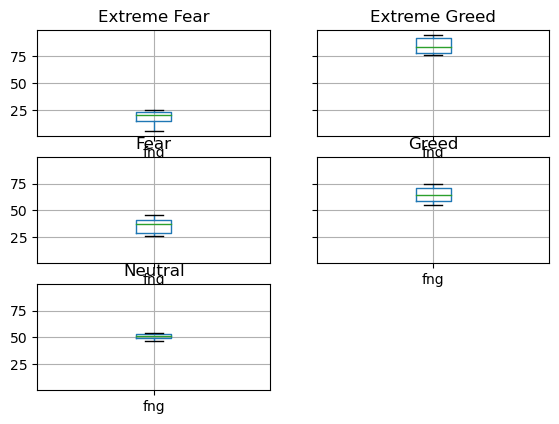

In [141]:
# Group by fng_classification and display boxplots for other columns
fng_df.groupby("fng_class").boxplot(column=["fng"])

# Show the plot
plt.show()

In [142]:
fng_df["fng_class"].value_counts()

fng_class
Fear             15793
Extreme Fear     12744
Greed             9576
Neutral           6264
Extreme Greed     4440
Name: count, dtype: int64

In [143]:
merged_df = pd.merge(fng_df, trading_df, how='inner', left_index=True, right_index=True)


In [144]:
merged_df = pd.merge(merged_df, CBBI_df, how='inner', left_index=True, right_index=True)

In [145]:
merged_df.dropna()

fng     fng_class     open     high      low    close  \
timestamp                                                           
2018-02-01   30          Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-02   15  Extreme Fear  1041.89  1047.20   980.00   982.19   
2018-02-03   40          Fear   923.67   930.00   908.82   923.27   
2018-02-04   24  Extreme Fear   971.00   975.00   950.88   952.00   
2018-02-05   11  Extreme Fear   821.60   843.99   821.00   838.85   
...         ...           ...      ...      ...      ...      ...   
2023-08-24   41          Fear  1679.61  1683.37  1679.24  1681.98   
2023-08-25   39          Fear  1661.16  1661.77  1655.99  1656.14   
2023-08-26   38          Fear  1653.79  1653.93  1651.63  1652.08   
2023-08-27   38          Fear  1647.03  1649.26  1646.64  1647.92   
2023-08-28   39          Fear  1658.33  1658.33  1649.07  1651.62   

                 volume  daily_returns       Price  PiCycle    RUPL   RHODL  \
timestamp                                                                     
2018-02-01   3465.84651       0.006392  10237.2998   0.9525  0.7244  0.9289   
2018-02-02  11924.49132      -0.057345   9559.0594   0.9525  0.6764  0.9263   
2018-02-03   5100.92040       0.001052   8612.5900   0.9525  0.6956  0.9224   
2018-02-04   4457.10819      -0.019567   8933.7900   0.9525  0.6850  0.9214   
2018-02-05   6036.08043       0.018566   8747.4006   0.9525  0.6153  0.9126   
...                 ...            ...         ...      ...     ...     ...   
2023-08-24   4994.12630       0.001411  26433.0000   0.5595  0.4944  0.1267   
2023-08-25   5725.34940      -0.003022  26122.0000   0.5579  0.4922  0.1227   
2023-08-26   2200.47960      -0.001040  26045.0000   0.5566  0.4904  0.1213   
2023-08-27   2138.16520       0.000534  25989.0000   0.5555  0.4933  0.1206   
2023-08-28  10892.11130      -0.004046  26004.8552   0.5546  0.4933  0.1205   

             Puell    2YMA  Trolololo    MVRV  ReserveRisk  Woobull  \
timestamp                                                             
2018-02-01  0.6852  0.7423     0.7697  0.6009       0.9793   0.6913   
2018-02-02  0.6834  0.7155     0.7380  0.6102       0.9613   0.6521   
2018-02-03  0.6159  0.6754     0.6900  0.6283       0.9232   0.6024   
2018-02-04  0.6762  0.6877     0.7060  0.6107       0.9367   0.6200   
2018-02-05  0.6813  0.6787     0.6958  0.5804       0.9291   0.6101   
...            ...     ...        ...     ...          ...      ...   
2023-08-24  0.8178  0.4082     0.1283  0.1995       0.1111   0.3069   
2023-08-25  0.7863  0.4008     0.1211  0.1977       0.1034   0.2997   
2023-08-26  0.7959  0.3996     0.1190  0.1964       0.1012   0.2980   
2023-08-27  0.6654  0.3990     0.1172  0.1986       0.0995   0.2968   
2023-08-28  0.6657  0.3996     0.1171  0.1985       0.1014   0.2973   

            Confidence CBBI_class  
timestamp                          
2018-02-01      0.7861    XX-High  
2018-02-02      0.7684    XX-High  
2018-02-03      0.7451    XX-High  
2018-02-04      0.7551    XX-High  
2018-02-05      0.7395    XX-High  
...                ...        ...  
2023-08-24      0.3503        Low  
2023-08-25      0.3424        Low  
2023-08-26      0.3421        Low  
2023-08-27      0.3273        Low  
2023-08-28      0.3276        Low  

[2034 rows x 20 columns]

In [146]:
merged_df

fng     fng_class     open     high      low    close  \
timestamp                                                           
2018-02-01   30          Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-02   15  Extreme Fear  1041.89  1047.20   980.00   982.19   
2018-02-03   40          Fear   923.67   930.00   908.82   923.27   
2018-02-04   24  Extreme Fear   971.00   975.00   950.88   952.00   
2018-02-05   11  Extreme Fear   821.60   843.99   821.00   838.85   
...         ...           ...      ...      ...      ...      ...   
2023-08-24   41          Fear  1679.61  1683.37  1679.24  1681.98   
2023-08-25   39          Fear  1661.16  1661.77  1655.99  1656.14   
2023-08-26   38          Fear  1653.79  1653.93  1651.63  1652.08   
2023-08-27   38          Fear  1647.03  1649.26  1646.64  1647.92   
2023-08-28   39          Fear  1658.33  1658.33  1649.07  1651.62   

                 volume  daily_returns       Price  PiCycle    RUPL   RHODL  \
timestamp                                                                     
2018-02-01   3465.84651       0.006392  10237.2998   0.9525  0.7244  0.9289   
2018-02-02  11924.49132      -0.057345   9559.0594   0.9525  0.6764  0.9263   
2018-02-03   5100.92040       0.001052   8612.5900   0.9525  0.6956  0.9224   
2018-02-04   4457.10819      -0.019567   8933.7900   0.9525  0.6850  0.9214   
2018-02-05   6036.08043       0.018566   8747.4006   0.9525  0.6153  0.9126   
...                 ...            ...         ...      ...     ...     ...   
2023-08-24   4994.12630       0.001411  26433.0000   0.5595  0.4944  0.1267   
2023-08-25   5725.34940      -0.003022  26122.0000   0.5579  0.4922  0.1227   
2023-08-26   2200.47960      -0.001040  26045.0000   0.5566  0.4904  0.1213   
2023-08-27   2138.16520       0.000534  25989.0000   0.5555  0.4933  0.1206   
2023-08-28  10892.11130      -0.004046  26004.8552   0.5546  0.4933  0.1205   

             Puell    2YMA  Trolololo    MVRV  ReserveRisk  Woobull  \
timestamp                                                             
2018-02-01  0.6852  0.7423     0.7697  0.6009       0.9793   0.6913   
2018-02-02  0.6834  0.7155     0.7380  0.6102       0.9613   0.6521   
2018-02-03  0.6159  0.6754     0.6900  0.6283       0.9232   0.6024   
2018-02-04  0.6762  0.6877     0.7060  0.6107       0.9367   0.6200   
2018-02-05  0.6813  0.6787     0.6958  0.5804       0.9291   0.6101   
...            ...     ...        ...     ...          ...      ...   
2023-08-24  0.8178  0.4082     0.1283  0.1995       0.1111   0.3069   
2023-08-25  0.7863  0.4008     0.1211  0.1977       0.1034   0.2997   
2023-08-26  0.7959  0.3996     0.1190  0.1964       0.1012   0.2980   
2023-08-27  0.6654  0.3990     0.1172  0.1986       0.0995   0.2968   
2023-08-28  0.6657  0.3996     0.1171  0.1985       0.1014   0.2973   

            Confidence CBBI_class  
timestamp                          
2018-02-01      0.7861    XX-High  
2018-02-02      0.7684    XX-High  
2018-02-03      0.7451    XX-High  
2018-02-04      0.7551    XX-High  
2018-02-05      0.7395    XX-High  
...                ...        ...  
2023-08-24      0.3503        Low  
2023-08-25      0.3424        Low  
2023-08-26      0.3421        Low  
2023-08-27      0.3273        Low  
2023-08-28      0.3276        Low  

[2034 rows x 20 columns]

---
## 2. Feature Engineering

# drop duplicate index label
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

In [147]:
import finta as ft
from finta import TA
import talib

ohlcv_df = merged_df

# List of time periods to use for Moving Averages calculation
timeperiods = [100,200,300,500,750,1000,1500]

df_eng = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    #tsma = TA.SMA(df_eng t).shift(1)
    sma = TA.SMA(df_eng,t)
    ema = TA.EMA(df_eng,t)
    atr = TA.ATR(df_eng,t)  #Average True Range
    adx = TA.ADX(df_eng,t) 
    rsi = TA.RSI(df_eng,t)
    hma = TA.HMA(df_eng,t)
    vama = TA.VAMA(df_eng,t)
 
    # calculate the Force Index
    force_index = pd.Series(df_eng['close'].diff(1) * df_eng['volume'], index=df_eng.index)
    force_ema = force_index.ewm(span=t, min_periods=0, adjust=True, ignore_na=False).mean()    
    
    #df['force_index'] = force_index
    #df[f'force_index_ema_{t}'] = force_ema # add the Force Index and its EMA to the DataFrame
    #df[f'TSMA_{t}'] = tsma
    df_eng[f'SMA_{t}'] = sma
    df_eng[f'EMA_{t}'] = ema
    df_eng[f'HMA_{t}'] = hma
    df_eng[f'VAMA_{t}'] = vama
    df_eng[f'ATR_{t}'] = atr
    df_eng[f'ADX_{t}'] = adx
    df_eng[f'RSI_{t}'] = rsi
    
    
# Calculate the Parabolic SAR
#sar = TA.PSAR(df)

# Add the SAR values and trend direction to the DataFrame
#df['sar'] = sar['psar']
#df['psarbear'] = sar['psarbear']
#df['psarbull'] = sar['psarbull']

df_eng['UO'] = TA.UO(df_eng)

# Adding Awesome Indicator (AO)
df_eng['AO'] = TA.AO(df_eng)
df_eng['OBV'] =TA.OBV(df_eng)

# Adding Chaikin Indicator 
df_eng['CHAIKIN'] = TA.CHAIKIN(df_eng)

# Adding Bollinger Bands
df_eng[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(df_eng)

# Calculate the Keltner Channel with TALIB
#df[['KC_UPPER','KC_MED','KC_LOWER']] = TA.KC(df)

# calculate Commodity Channel Index (CCI)
df_eng['cci'] = TA.CCI(df_eng)

# assuming you have OHLCV data in a pandas dataframe called "df"
#volume_momentum = talib.MOM(df['volume'])

In [148]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [149]:
# drop duplicate index label
df_eng = df_eng[~df_eng.index.duplicated(keep='first')]


In [150]:
df_eng

fng     fng_class     open     high      low    close  \
timestamp                                                           
2018-02-01   30          Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-02   15  Extreme Fear  1041.89  1047.20   980.00   982.19   
2018-02-03   40          Fear   923.67   930.00   908.82   923.27   
2018-02-04   24  Extreme Fear   971.00   975.00   950.88   952.00   
2018-02-05   11  Extreme Fear   821.60   843.99   821.00   838.85   
...         ...           ...      ...      ...      ...      ...   
2023-08-24   41          Fear  1679.61  1683.37  1679.24  1681.98   
2023-08-25   39          Fear  1661.16  1661.77  1655.99  1656.14   
2023-08-26   38          Fear  1653.79  1653.93  1651.63  1652.08   
2023-08-27   38          Fear  1647.03  1649.26  1646.64  1647.92   
2023-08-28   39          Fear  1658.33  1658.33  1649.07  1651.62   

                 volume  daily_returns       Price  PiCycle  ...   ADX_1500  \
timestamp                                                    ...              
2018-02-01   3465.84651       0.006392  10237.2998   0.9525  ...        NaN   
2018-02-02  11924.49132      -0.057345   9559.0594   0.9525  ...        NaN   
2018-02-03   5100.92040       0.001052   8612.5900   0.9525  ...        NaN   
2018-02-04   4457.10819      -0.019567   8933.7900   0.9525  ...        NaN   
2018-02-05   6036.08043       0.018566   8747.4006   0.9525  ...        NaN   
...                 ...            ...         ...      ...  ...        ...   
2023-08-24   4994.12630       0.001411  26433.0000   0.5595  ...  10.849427   
2023-08-25   5725.34940      -0.003022  26122.0000   0.5579  ...  10.833991   
2023-08-26   2200.47960      -0.001040  26045.0000   0.5566  ...  10.818658   
2023-08-27   2138.16520       0.000534  25989.0000   0.5555  ...  10.803433   
2023-08-28  10892.11130      -0.004046  26004.8552   0.5546  ...  10.788168   

             RSI_1500         UO          AO           OBV      CHAIKIN  \
timestamp                                                                 
2018-02-01        NaN        NaN         NaN           NaN          NaN   
2018-02-02   0.000000        NaN         NaN -1.192449e+04          NaN   
2018-02-03   0.000000        NaN         NaN -1.702541e+04          NaN   
2018-02-04  12.111067        NaN         NaN -1.256830e+04          NaN   
2018-02-05   8.198112        NaN         NaN -1.860438e+04          NaN   
...               ...        ...         ...           ...          ...   
2023-08-24  50.277253  33.452711 -147.282765  2.298097e+06  5865.687322   
2023-08-25  50.252059  37.150150 -142.824382  2.292372e+06  2370.900597   
2023-08-26  50.248100  38.454497 -142.588441  2.290171e+06   299.498858   
2023-08-27  50.244042  36.551181 -139.528853  2.288033e+06  -590.699901   
2023-08-28  50.247618  34.823486 -130.564206  2.298925e+06 -2458.104590   

               BB_UPPER     BB_MED     BB_LOWER         cci  
timestamp                                                    
2018-02-01          NaN        NaN          NaN         NaN  
2018-02-02          NaN        NaN          NaN  -66.666667  
2018-02-03          NaN        NaN          NaN  -86.741546  
2018-02-04          NaN        NaN          NaN  -46.280275  
2018-02-05          NaN        NaN          NaN -115.866012  
...                 ...        ...          ...         ...  
2023-08-24  1949.263676  1781.1160  1612.968324  -86.256534  
2023-08-25  1947.503564  1772.3195  1597.135436  -92.774042  
2023-08-26  1943.385904  1763.0940  1582.802096  -85.863264  
2023-08-27  1938.401059  1753.9910  1569.580941  -80.132231  
2023-08-28  1930.475028  1744.8125  1559.149972  -69.337758  

[2034 rows x 77 columns]

In [151]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [152]:
# Detecting columns with NaN
def detect_Nan(df) : 
    columns_with_nan = df.columns[df.isna().mean() > 0.5]
    return(columns_with_nan)

In [153]:
# Drop columns with more than 50% NaN values
columns_with_nan = detect_Nan(df_eng)
print("Columns with more than 50% NaN values:")
print(columns_with_nan)


# df_eng_dropped = df_eng.drop(columns=columns_with_nan, axis=1)

Columns with more than 50% NaN values:
Index(['VAMA_750', 'HMA_1000', 'VAMA_1000', 'SMA_1500', 'HMA_1500',
       'VAMA_1500', 'ATR_1500', 'ADX_1500'],
      dtype='object')


In [154]:
# Drop columns with more than 50% NaN values
df_eng_dropped = df_eng.drop(columns=columns_with_nan, axis=1)

In [155]:
detect_Nan(df_eng_dropped)

Index([], dtype='object')

In [156]:
df_eng = df_eng_dropped.copy()

In [157]:
# calculate the Ichimoku Kinko Hyo indicator
# Calculate the conversion line
nine_period_high = df_eng['high'].rolling(window=9).max()
nine_period_low = df_eng['low'].rolling(window=9).min()
df_eng['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Calculate the base line
periods = 26
twenty_six_period_high = df_eng['high'].rolling(window=periods).max()
twenty_six_period_low = df_eng['low'].rolling(window=periods).min()
df_eng['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

# Calculate the leading span A
df_eng['senkou_span_a'] = ((df_eng['tenkan_sen'] + df_eng['kijun_sen']) / 2).shift(periods=periods)

# Calculate the leading span B
periods2 = 52
fifty_two_period_high = df_eng['high'].rolling(window=periods2).max()
fifty_two_period_low = df_eng['low'].rolling(window=periods2).min()
df_eng['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)

# Calculate the lagging span
#df_eng['chikou_span'] = df_eng['close'].shift(periods=-periods)


In [158]:
# Drop columns with more than 50% NaN values
columns_with_nan = detect_Nan(df_eng)
print("Columns with more than 50% NaN values:")
print(columns_with_nan)

Columns with more than 50% NaN values:
Index([], dtype='object')


In [159]:
df_eng.tail()

fng fng_class     open     high      low    close      volume  \
timestamp                                                                   
2023-08-24   41      Fear  1679.61  1683.37  1679.24  1681.98   4994.1263   
2023-08-25   39      Fear  1661.16  1661.77  1655.99  1656.14   5725.3494   
2023-08-26   38      Fear  1653.79  1653.93  1651.63  1652.08   2200.4796   
2023-08-27   38      Fear  1647.03  1649.26  1646.64  1647.92   2138.1652   
2023-08-28   39      Fear  1658.33  1658.33  1649.07  1651.62  10892.1113   

            daily_returns       Price  PiCycle  ...           OBV  \
timestamp                                       ...                 
2023-08-24       0.001411  26433.0000   0.5595  ...  2.298097e+06   
2023-08-25      -0.003022  26122.0000   0.5579  ...  2.292372e+06   
2023-08-26      -0.001040  26045.0000   0.5566  ...  2.290171e+06   
2023-08-27       0.000534  25989.0000   0.5555  ...  2.288033e+06   
2023-08-28      -0.004046  26004.8552   0.5546  ...  2.298925e+06   

                CHAIKIN     BB_UPPER     BB_MED     BB_LOWER        cci  \
timestamp                                                                 
2023-08-24  5865.687322  1949.263676  1781.1160  1612.968324 -86.256534   
2023-08-25  2370.900597  1947.503564  1772.3195  1597.135436 -92.774042   
2023-08-26   299.498858  1943.385904  1763.0940  1582.802096 -85.863264   
2023-08-27  -590.699901  1938.401059  1753.9910  1569.580941 -80.132231   
2023-08-28 -2458.104590  1930.475028  1744.8125  1559.149972 -69.337758   

            tenkan_sen  kijun_sen  senkou_span_a senkou_span_b  
timestamp                                                       
2023-08-24    1731.775   1757.315      1899.2225       1837.81  
2023-08-25    1721.550   1755.800      1899.2225       1837.81  
2023-08-26    1666.255   1755.800      1897.8400       1837.81  
2023-08-27    1659.380   1755.800      1897.8400       1837.81  
2023-08-28    1659.380   1746.805      1900.6625       1837.81  

[5 rows x 73 columns]

#### Add a daily return values column to the DataFrame

In [160]:
# Calculate the daily returns using the closing prices and the pct_change function
df_eng["daily_returns"] = df_eng["close"].pct_change()

# Drop all NaN values from the DataFrame
#df_eng = df_eng.dropna()

# Review the DataFrame
df_eng.head()

fng     fng_class     open     high      low    close  \
timestamp                                                           
2018-02-01   30          Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-02   15  Extreme Fear  1041.89  1047.20   980.00   982.19   
2018-02-03   40          Fear   923.67   930.00   908.82   923.27   
2018-02-04   24  Extreme Fear   971.00   975.00   950.88   952.00   
2018-02-05   11  Extreme Fear   821.60   843.99   821.00   838.85   

                 volume  daily_returns       Price  PiCycle  ...          OBV  \
timestamp                                                    ...                
2018-02-01   3465.84651            NaN  10237.2998   0.9525  ...          NaN   
2018-02-02  11924.49132      -0.132341   9559.0594   0.9525  ... -11924.49132   
2018-02-03   5100.92040      -0.059988   8612.5900   0.9525  ... -17025.41172   
2018-02-04   4457.10819       0.031118   8933.7900   0.9525  ... -12568.30353   
2018-02-05   6036.08043      -0.118855   8747.4006   0.9525  ... -18604.38396   

            CHAIKIN  BB_UPPER  BB_MED  BB_LOWER         cci  tenkan_sen  \
timestamp                                                                 
2018-02-01      NaN       NaN     NaN       NaN         NaN         NaN   
2018-02-02      NaN       NaN     NaN       NaN  -66.666667         NaN   
2018-02-03      NaN       NaN     NaN       NaN  -86.741546         NaN   
2018-02-04      NaN       NaN     NaN       NaN  -46.280275         NaN   
2018-02-05      NaN       NaN     NaN       NaN -115.866012         NaN   

            kijun_sen  senkou_span_a senkou_span_b  
timestamp                                           
2018-02-01        NaN            NaN           NaN  
2018-02-02        NaN            NaN           NaN  
2018-02-03        NaN            NaN           NaN  
2018-02-04        NaN            NaN           NaN  
2018-02-05        NaN            NaN           NaN  

[5 rows x 73 columns]

In [161]:
# Assuming your dataframe is named 'df' and has a DateTimeIndex
weekly_pct_change = df_eng['close'].pct_change(periods=7*24).mul(100)

# Add the weekly percent change column to the dataframe
df_eng['weekly_returns'] = weekly_pct_change

In [162]:
### CAlculatin the slope
import numpy as np

# Assuming your dataframe is named 'df' and has a DateTimeIndex
window_size = 7 * 24  # 7 days * 24 hours

# Calculate the slope using numpy.polyfit
prices = df_eng['close'].values
timestamps = df_eng.index.values.astype(np.int64) // 10**9  # Convert timestamps to seconds
slopes = np.polyfit(timestamps[-window_size:], prices[-window_size:], deg=1)

# Assign the slope values to a new column in the dataframe
df_eng['price_slope'] = slopes[0]

In [163]:
df_eng

fng     fng_class     open     high      low    close  \
timestamp                                                           
2018-02-01   30          Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-02   15  Extreme Fear  1041.89  1047.20   980.00   982.19   
2018-02-03   40          Fear   923.67   930.00   908.82   923.27   
2018-02-04   24  Extreme Fear   971.00   975.00   950.88   952.00   
2018-02-05   11  Extreme Fear   821.60   843.99   821.00   838.85   
...         ...           ...      ...      ...      ...      ...   
2023-08-24   41          Fear  1679.61  1683.37  1679.24  1681.98   
2023-08-25   39          Fear  1661.16  1661.77  1655.99  1656.14   
2023-08-26   38          Fear  1653.79  1653.93  1651.63  1652.08   
2023-08-27   38          Fear  1647.03  1649.26  1646.64  1647.92   
2023-08-28   39          Fear  1658.33  1658.33  1649.07  1651.62   

                 volume  daily_returns       Price  PiCycle  ...     BB_UPPER  \
timestamp                                                    ...                
2018-02-01   3465.84651            NaN  10237.2998   0.9525  ...          NaN   
2018-02-02  11924.49132      -0.132341   9559.0594   0.9525  ...          NaN   
2018-02-03   5100.92040      -0.059988   8612.5900   0.9525  ...          NaN   
2018-02-04   4457.10819       0.031118   8933.7900   0.9525  ...          NaN   
2018-02-05   6036.08043      -0.118855   8747.4006   0.9525  ...          NaN   
...                 ...            ...         ...      ...  ...          ...   
2023-08-24   4994.12630       0.029918  26433.0000   0.5595  ...  1949.263676   
2023-08-25   5725.34940      -0.015363  26122.0000   0.5579  ...  1947.503564   
2023-08-26   2200.47960      -0.002451  26045.0000   0.5566  ...  1943.385904   
2023-08-27   2138.16520      -0.002518  25989.0000   0.5555  ...  1938.401059   
2023-08-28  10892.11130       0.002245  26004.8552   0.5546  ...  1930.475028   

               BB_MED     BB_LOWER         cci  tenkan_sen  kijun_sen  \
timestamp                                                               
2018-02-01        NaN          NaN         NaN         NaN        NaN   
2018-02-02        NaN          NaN  -66.666667         NaN        NaN   
2018-02-03        NaN          NaN  -86.741546         NaN        NaN   
2018-02-04        NaN          NaN  -46.280275         NaN        NaN   
2018-02-05        NaN          NaN -115.866012         NaN        NaN   
...               ...          ...         ...         ...        ...   
2023-08-24  1781.1160  1612.968324  -86.256534    1731.775   1757.315   
2023-08-25  1772.3195  1597.135436  -92.774042    1721.550   1755.800   
2023-08-26  1763.0940  1582.802096  -85.863264    1666.255   1755.800   
2023-08-27  1753.9910  1569.580941  -80.132231    1659.380   1755.800   
2023-08-28  1744.8125  1559.149972  -69.337758    1659.380   1746.805   

            senkou_span_a  senkou_span_b  weekly_returns price_slope  
timestamp                                                             
2018-02-01            NaN            NaN             NaN   -0.000003  
2018-02-02            NaN            NaN             NaN   -0.000003  
2018-02-03            NaN            NaN             NaN   -0.000003  
2018-02-04            NaN            NaN             NaN   -0.000003  
2018-02-05            NaN            NaN             NaN   -0.000003  
...                   ...            ...             ...         ...  
2023-08-24      1899.2225        1837.81        9.514601   -0.000003  
2023-08-25      1899.2225        1837.81       16.146995   -0.000003  
2023-08-26      1897.8400        1837.81       15.081814   -0.000003  
2023-08-27      1897.8400        1837.81       12.567455   -0.000003  
2023-08-28      1900.6625        1837.81        2.465444   -0.000003  

[2034 rows x 75 columns]

In [164]:
df_eng.dropna(inplace=True)

In [165]:
df_eng

fng fng_class     open     high      low    close       volume  \
timestamp                                                                    
2020-10-28   70     Greed   403.41   406.16   402.42   405.35  21779.55712   
2020-10-29   67     Greed   388.22   390.20   387.71   388.17  19872.71065   
2020-10-30   74     Greed   387.12   391.59   383.28   390.74  42240.10139   
2020-10-31   73     Greed   382.59   384.64   379.90   383.84  20249.69114   
2020-11-01   72     Greed   386.44   390.65   384.61   386.76  30230.17745   
...         ...       ...      ...      ...      ...      ...          ...   
2023-08-24   41      Fear  1679.61  1683.37  1679.24  1681.98   4994.12630   
2023-08-25   39      Fear  1661.16  1661.77  1655.99  1656.14   5725.34940   
2023-08-26   38      Fear  1653.79  1653.93  1651.63  1652.08   2200.47960   
2023-08-27   38      Fear  1647.03  1649.26  1646.64  1647.92   2138.16520   
2023-08-28   39      Fear  1658.33  1658.33  1649.07  1651.62  10892.11130   

            daily_returns       Price  PiCycle  ...     BB_UPPER     BB_MED  \
timestamp                                       ...                           
2020-10-28       0.026930  13654.2145   0.5633  ...   420.340855   384.1465   
2020-10-29      -0.042383  13275.8800   0.5649  ...   418.351313   386.0945   
2020-10-30       0.006621  13441.8800   0.5666  ...   418.308589   387.2785   
2020-10-31      -0.017659  13546.2700   0.5682  ...   417.990693   387.9625   
2020-11-01       0.007607  13831.6300   0.5699  ...   417.905547   388.6075   
...                   ...         ...      ...  ...          ...        ...   
2023-08-24       0.029918  26433.0000   0.5595  ...  1949.263676  1781.1160   
2023-08-25      -0.015363  26122.0000   0.5579  ...  1947.503564  1772.3195   
2023-08-26      -0.002451  26045.0000   0.5566  ...  1943.385904  1763.0940   
2023-08-27      -0.002518  25989.0000   0.5555  ...  1938.401059  1753.9910   
2023-08-28       0.002245  26004.8552   0.5546  ...  1930.475028  1744.8125   

               BB_LOWER        cci  tenkan_sen  kijun_sen  senkou_span_a  \
timestamp                                                                  
2020-10-28   347.952145  94.369591     390.905    376.435       346.7975   
2020-10-29   353.837687  14.833532     390.905    376.435       353.5550   
2020-10-30   356.248411   9.118718     398.675    376.435       353.5550   
2020-10-31   357.934307 -25.126862     396.985    376.435       353.5550   
2020-11-01   359.309453  -4.327998     396.660    376.435       353.5550   
...                 ...        ...         ...        ...            ...   
2023-08-24  1612.968324 -86.256534    1731.775   1757.315      1899.2225   
2023-08-25  1597.135436 -92.774042    1721.550   1755.800      1899.2225   
2023-08-26  1582.802096 -85.863264    1666.255   1755.800      1897.8400   
2023-08-27  1569.580941 -80.132231    1659.380   1755.800      1897.8400   
2023-08-28  1559.149972 -69.337758    1659.380   1746.805      1900.6625   

            senkou_span_b  weekly_returns price_slope  
timestamp                                              
2020-10-28        397.785      112.236243   -0.000003  
2020-10-29        397.785       95.640341   -0.000003  
2020-10-30        397.785       92.758127   -0.000003  
2020-10-31        397.785       95.020831   -0.000003  
2020-11-01        397.785       91.550691   -0.000003  
...                   ...             ...         ...  
2023-08-24       1837.810        9.514601   -0.000003  
2023-08-25       1837.810       16.146995   -0.000003  
2023-08-26       1837.810       15.081814   -0.000003  
2023-08-27       1837.810       12.567455   -0.000003  
2023-08-28       1837.810        2.465444   -0.000003  

[1035 rows x 75 columns]

---
## 3. Pre-Processing
### 3.1 Remove highly-correlated features

In [166]:
df_feats = df_eng.copy()
# df_feats = df_feats.dropna()
df_feats.columns

Index(['fng', 'fng_class', 'open', 'high', 'low', 'close', 'volume',
       'daily_returns', 'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA',
       'Trolololo', 'MVRV', 'ReserveRisk', 'Woobull', 'Confidence',
       'CBBI_class', 'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100',
       'ADX_100', 'RSI_100', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200',
       'ATR_200', 'ADX_200', 'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300',
       'VAMA_300', 'ATR_300', 'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500',
       'HMA_500', 'VAMA_500', 'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750',
       'EMA_750', 'HMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000',
       'EMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000', 'EMA_1500', 'RSI_1500',
       'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci',
       'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b',
       'weekly_returns', 'price_slope'],
      dtype='object')

In [167]:
# df_feats_col = ['fng','fng_class', 'open', 'high', 'low', 'close', 'volume',
#        'daily_returns', 'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA',
#        'Trolololo', 'MVRV', 'ReserveRisk', 'Woobull', 'Confidence',
#        'CBBI_class', 'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100',
#        'ADX_100', 'RSI_100', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200',
#        'ATR_200', 'ADX_200', 'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300',
#        'VAMA_300', 'ATR_300', 'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500',
#        'HMA_500', 'VAMA_500', 'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750',
#        'EMA_750', 'HMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000',
#        'EMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000', 'EMA_1500', 'RSI_1500',
#        'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci',
#        'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b',
#        'weekly_returns', 'price_slope']

# df_feats = df_feats[df_feats_col]

In [168]:

# # Calculate correlation matrix
# # calculate the correlation matrix of the features
# corr_matrix = df_feats.corr()

# # set the threshold for correlation value
# corr_threshold = 0.55

# # find the highly correlated features and drop them from the dataframe
# high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
# high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
# df_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# # select the remaining features with low correlation
# low_corr_features = df_feats.columns.tolist()

# # print the low correlated features
# print(low_corr_features)

In [169]:
# df_feats = df_feats[['volume', 'fng', 'PiCycle', 'SMA_100', 'UO', 'AO', 'CHAIKIN', 'price_slope']]
# df_feats[['fng_class','weekly_returns','price_slope']] = df_eng[['fng_class','weekly_returns','price_slope']]

In [170]:
df_feats = df_feats[['fng_class', 'volume', 'price_slope']]

In [171]:
# replace spaces with underscores in the categorical column
df_feats["fng_class"] = df_feats["fng_class"].str.replace("Extreme ", "Hi_")

In [172]:
df_feats["fng_class"].value_counts()

fng_class
Hi_Fear     282
Fear        235
Greed       222
Neutral     156
Hi_Greed    140
Name: count, dtype: int64

In [173]:
# Get dummy variables for the categorical column
dummy_df = pd.get_dummies(df_feats['fng_class'], prefix='fng')

# Concatenate the original DataFrame with the dummy-encoded DataFrame
df_encoded = pd.concat([df_feats, dummy_df], axis=1)

# Drop the original categorical column (optional)
df_encoded.drop('fng_class', axis=1, inplace=True)

df_encoded

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                                
2020-10-28  21779.55712    -0.000003     False       True        False   
2020-10-29  19872.71065    -0.000003     False       True        False   
2020-10-30  42240.10139    -0.000003     False       True        False   
2020-10-31  20249.69114    -0.000003     False       True        False   
2020-11-01  30230.17745    -0.000003     False       True        False   
...                 ...          ...       ...        ...          ...   
2023-08-24   4994.12630    -0.000003      True      False        False   
2023-08-25   5725.34940    -0.000003      True      False        False   
2023-08-26   2200.47960    -0.000003      True      False        False   
2023-08-27   2138.16520    -0.000003      True      False        False   
2023-08-28  10892.11130    -0.000003      True      False        False   

            fng_Hi_Greed  fng_Neutral  
timestamp                              
2020-10-28         False        False  
2020-10-29         False        False  
2020-10-30         False        False  
2020-10-31         False        False  
2020-11-01         False        False  
...                  ...          ...  
2023-08-24         False        False  
2023-08-25         False        False  
2023-08-26         False        False  
2023-08-27         False        False  
2023-08-28         False        False  

[1035 rows x 7 columns]

In [174]:
df_encoded.columns


Index(['volume', 'price_slope', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral'],
      dtype='object')

In [175]:
# df_encoded_cols = ['fng_value', 'ADX_100', 'RSI_100', 'UO', 'AO',
#                      'weekly_pct_change']

In [176]:
# df_encoded = df_encoded[df_encoded_cols] 

In [177]:
df_encoded

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                                
2020-10-28  21779.55712    -0.000003     False       True        False   
2020-10-29  19872.71065    -0.000003     False       True        False   
2020-10-30  42240.10139    -0.000003     False       True        False   
2020-10-31  20249.69114    -0.000003     False       True        False   
2020-11-01  30230.17745    -0.000003     False       True        False   
...                 ...          ...       ...        ...          ...   
2023-08-24   4994.12630    -0.000003      True      False        False   
2023-08-25   5725.34940    -0.000003      True      False        False   
2023-08-26   2200.47960    -0.000003      True      False        False   
2023-08-27   2138.16520    -0.000003      True      False        False   
2023-08-28  10892.11130    -0.000003      True      False        False   

            fng_Hi_Greed  fng_Neutral  
timestamp                              
2020-10-28         False        False  
2020-10-29         False        False  
2020-10-30         False        False  
2020-10-31         False        False  
2020-11-01         False        False  
...                  ...          ...  
2023-08-24         False        False  
2023-08-25         False        False  
2023-08-26         False        False  
2023-08-27         False        False  
2023-08-28         False        False  

[1035 rows x 7 columns]

---
### 4 Clustering

> values that works well: dbscan = DBSCAN(eps=3, min_samples=600)

In [178]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(df_encoded)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=100) #3 / 200 previosuly 
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the original dataframe
df_encoded['cluster'] = clusters

---
### Alternative with K-means and elbow methode for optimization

In [179]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # Assuming your dataframe is named 'df_encoded'

# # Define a range of values for the number of clusters
# num_clusters_range = range(1, 11)
# wcss = []  # Within-cluster sum of squares

# # Compute WCSS for different values of num_clusters
# for num_clusters in num_clusters_range:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     kmeans.fit(df_encoded)
#     wcss.append(kmeans.inertia_)  # Append the WCSS to the list

# # Plot the elbow curve
# plt.plot(num_clusters_range, wcss)
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.title('Elbow Method')
# plt.show()

In [180]:
# # Specify the number of clusters
# num_clusters = 4

# # Perform K-means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(df_encoded)

# # Add the cluster labels to the dataframe
# df_encoded['cluster'] = clusters

In [181]:
unique_clusters = df_encoded['cluster'].unique()
print(unique_clusters)

[ 0  1 -1  2  3  4]


In [182]:
df_encoded[['close','daily_returns']] = df_eng[['close','daily_returns']]

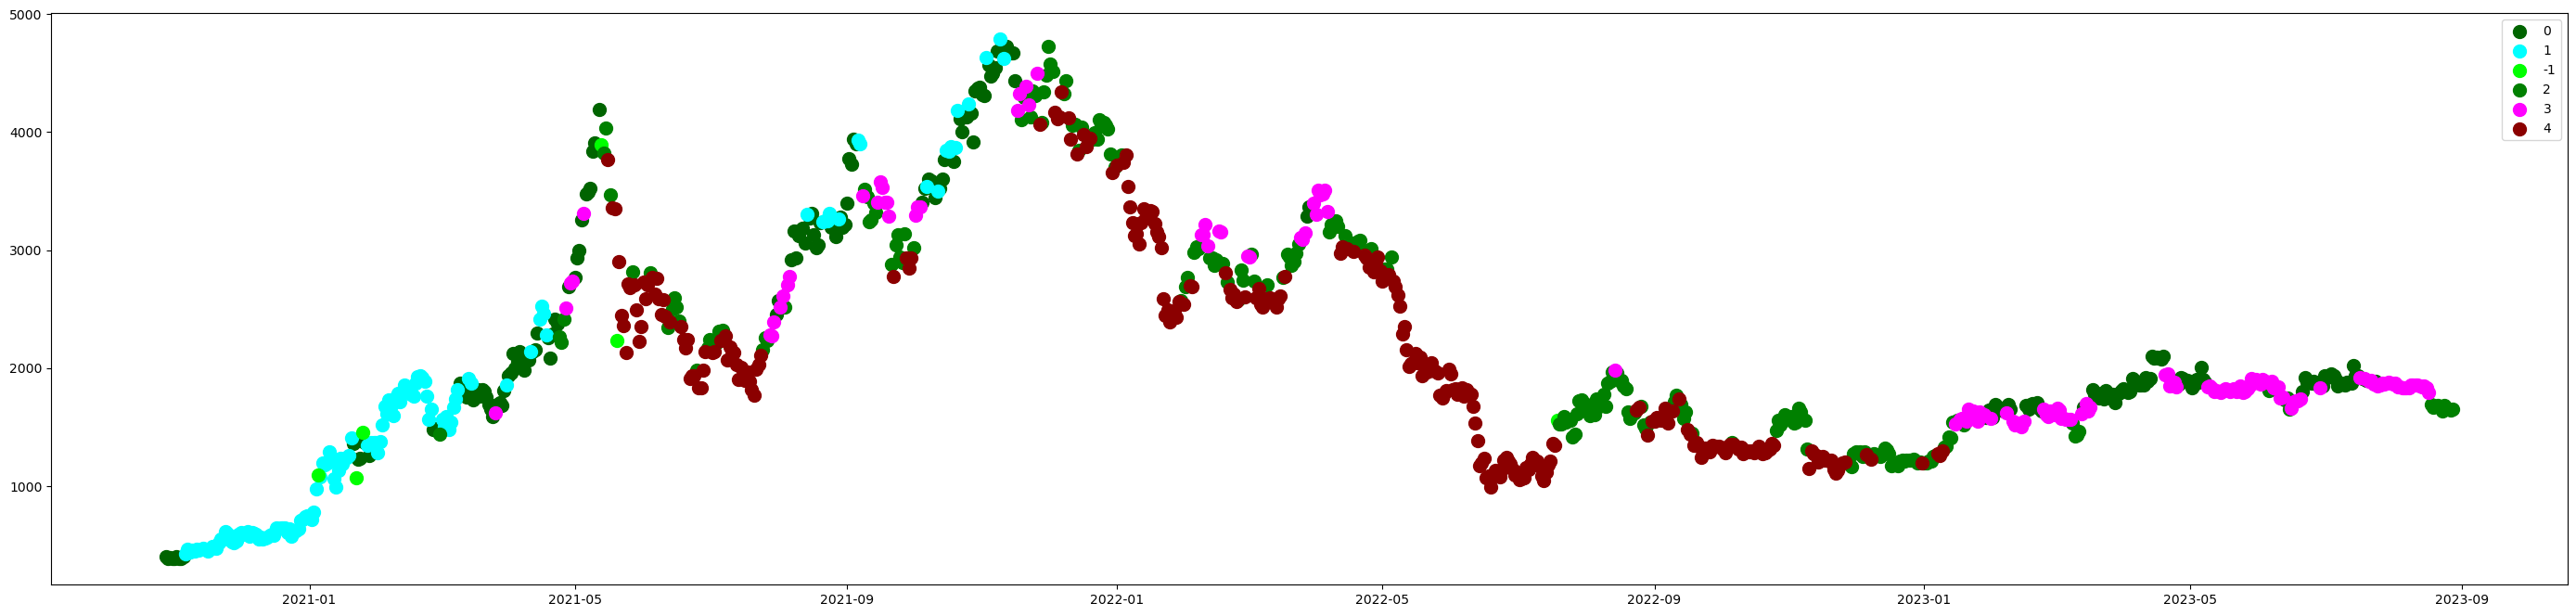

In [183]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 8))
for label, color in zip(df_encoded['cluster'].unique(), ['darkgreen', 'cyan', 'lime', 'green', 'magenta','darkred']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=100)
ax.legend()
plt.show()

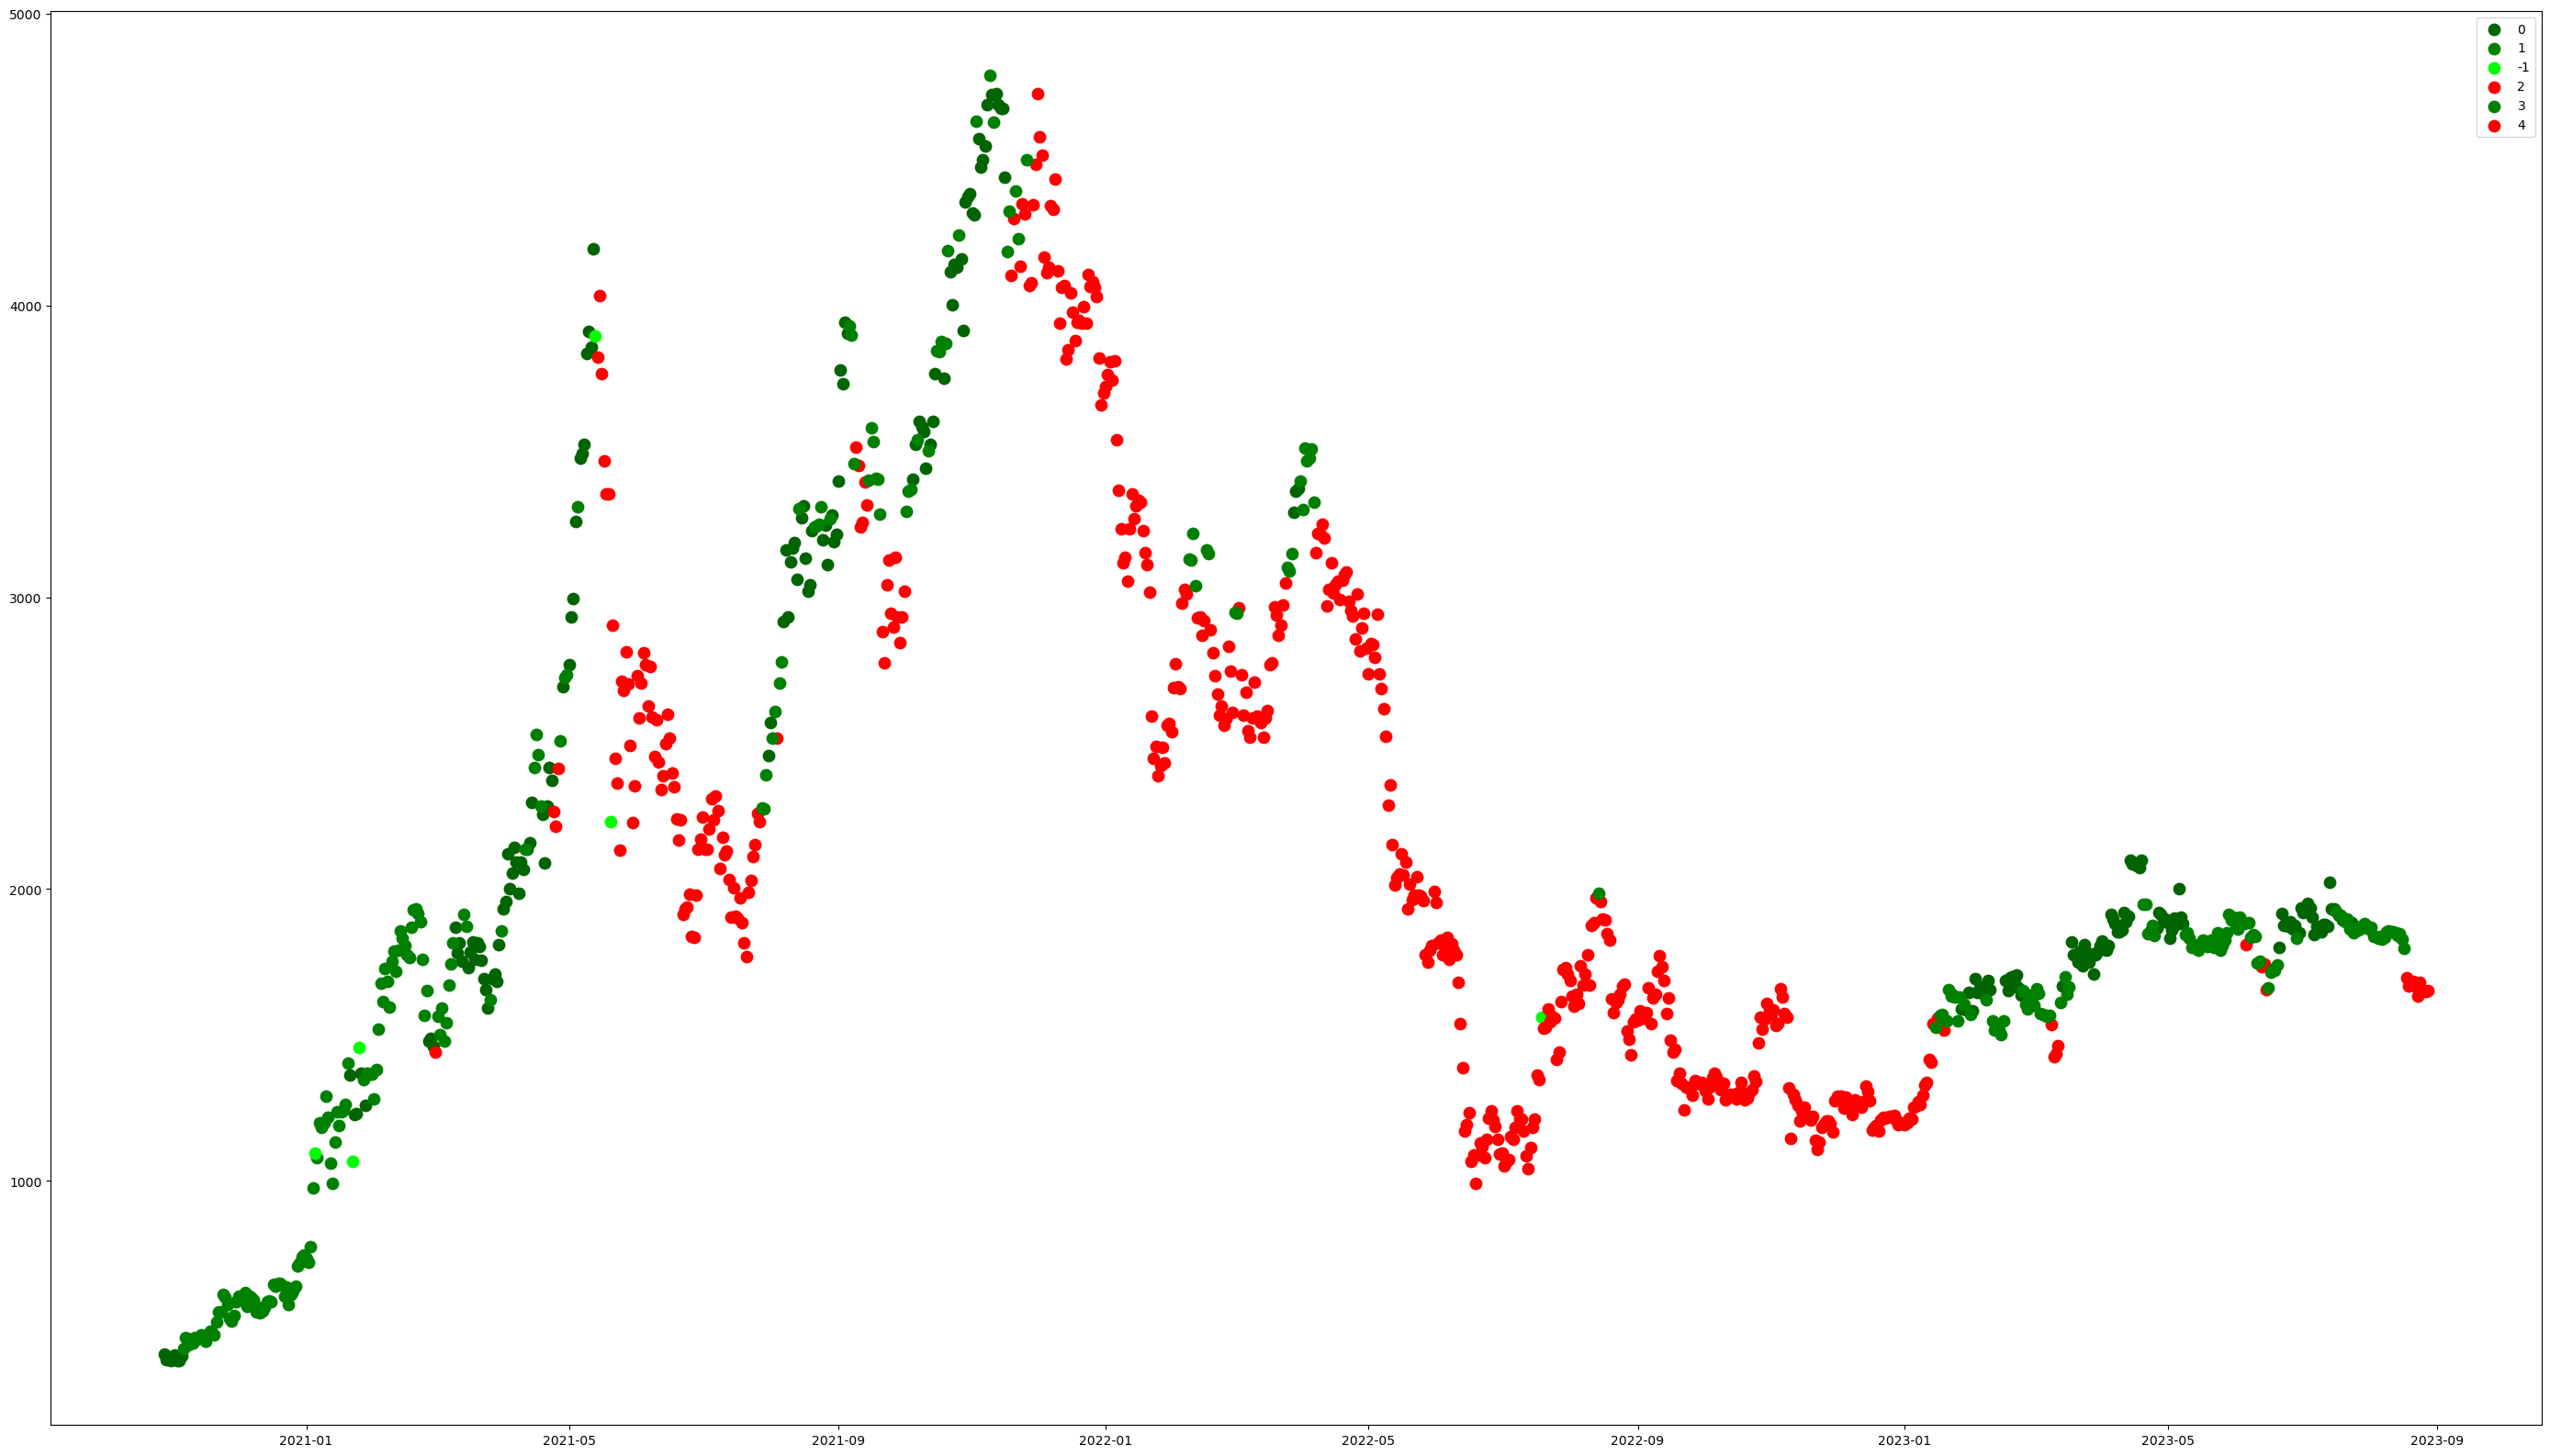

In [184]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_encoded['cluster'].unique(), ['darkgreen', 'green', 'lime', 'red', 'green','red']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=80)
ax.legend()
plt.show()

In [185]:
df_encoded

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                                
2020-10-28  21779.55712    -0.000003     False       True        False   
2020-10-29  19872.71065    -0.000003     False       True        False   
2020-10-30  42240.10139    -0.000003     False       True        False   
2020-10-31  20249.69114    -0.000003     False       True        False   
2020-11-01  30230.17745    -0.000003     False       True        False   
...                 ...          ...       ...        ...          ...   
2023-08-24   4994.12630    -0.000003      True      False        False   
2023-08-25   5725.34940    -0.000003      True      False        False   
2023-08-26   2200.47960    -0.000003      True      False        False   
2023-08-27   2138.16520    -0.000003      True      False        False   
2023-08-28  10892.11130    -0.000003      True      False        False   

            fng_Hi_Greed  fng_Neutral  cluster    close  daily_returns  
timestamp                                                               
2020-10-28         False        False        0   405.35       0.026930  
2020-10-29         False        False        0   388.17      -0.042383  
2020-10-30         False        False        0   390.74       0.006621  
2020-10-31         False        False        0   383.84      -0.017659  
2020-11-01         False        False        0   386.76       0.007607  
...                  ...          ...      ...      ...            ...  
2023-08-24         False        False        2  1681.98       0.029918  
2023-08-25         False        False        2  1656.14      -0.015363  
2023-08-26         False        False        2  1652.08      -0.002451  
2023-08-27         False        False        2  1647.92      -0.002518  
2023-08-28         False        False        2  1651.62       0.002245  

[1035 rows x 10 columns]

In [186]:
df_eda  = df_encoded.copy()


In [187]:
df_eda [['fng','fng_class','daily_returns','weekly_returns']] = df_eng [['fng','fng_class','daily_returns','weekly_returns']]

In [188]:
df_eda.columns

Index(['volume', 'price_slope', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral', 'cluster', 'close', 'daily_returns',
       'fng', 'fng_class', 'weekly_returns'],
      dtype='object')

<Axes: xlabel='cluster', ylabel='fng'>

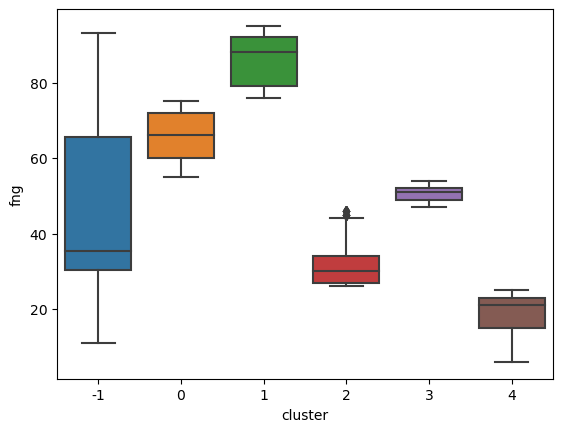

In [189]:
import seaborn as sns

# create a new DataFrame with just the relevant columns
cluster_df = df_eda[['cluster', 'fng', 'daily_returns','weekly_returns']]

# create boxplots of fng_value and actual_returns for each cluster
sns.boxplot(data=cluster_df, x='cluster', y='fng')


<Axes: xlabel='cluster', ylabel='weekly_returns'>

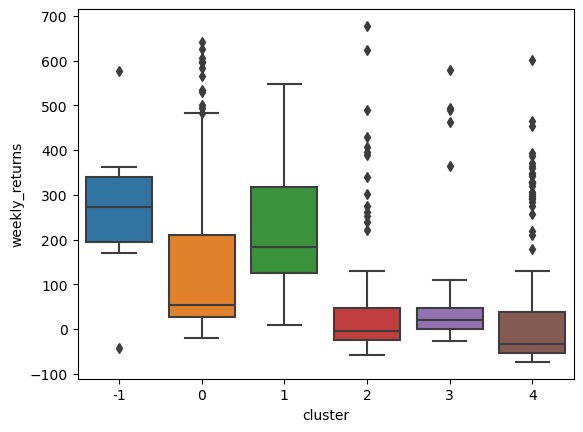

In [190]:
sns.boxplot(data=cluster_df, x='cluster', y='weekly_returns')

> keeping previous code : # Replace cluster labels -1 and 3 with 1, and the rest with 0
> df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==4)), 0, 1)

In [191]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
df_eda['signal'] = np.where(((df_eda['cluster']==2)
                            | (df_eda['cluster']==3 )
                             | (df_eda['cluster']==4 )
                             ), 0, 1)

In [192]:
df_eda['signal'].unique()

array([1, 0])

In [193]:
df_eda['signal'].value_counts()

signal
0    669
1    366
Name: count, dtype: int64

In [194]:
df_eda[['signal','fng']]

signal  fng
timestamp              
2020-10-28       1   70
2020-10-29       1   67
2020-10-30       1   74
2020-10-31       1   73
2020-11-01       1   72
...            ...  ...
2023-08-24       0   41
2023-08-25       0   39
2023-08-26       0   38
2023-08-27       0   38
2023-08-28       0   39

[1035 rows x 2 columns]

In [195]:
df_eda.columns

Index(['volume', 'price_slope', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral', 'cluster', 'close', 'daily_returns',
       'fng', 'fng_class', 'weekly_returns', 'signal'],
      dtype='object')

In [196]:
df_eda['signal'].loc[(df_eda['fng'] < 15) & (df_eda['weekly_returns'] > 0)] = 1 #25



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [197]:
# df_eda['signal'].loc[(df_eda['fng'] > 85) & (df_eda['weekly_returns'] < 0)] = 0 #85
#df_eda['signal'].loc[(df_eda['fng'] > 90)] = 0

# df_eda['signal'].loc[(df_eda['fng'] > 60) & (df_eda['weekly_returns'] < 0)] = 0 #85

In [198]:
df_eda['signal'].value_counts()

signal
0    659
1    376
Name: count, dtype: int64

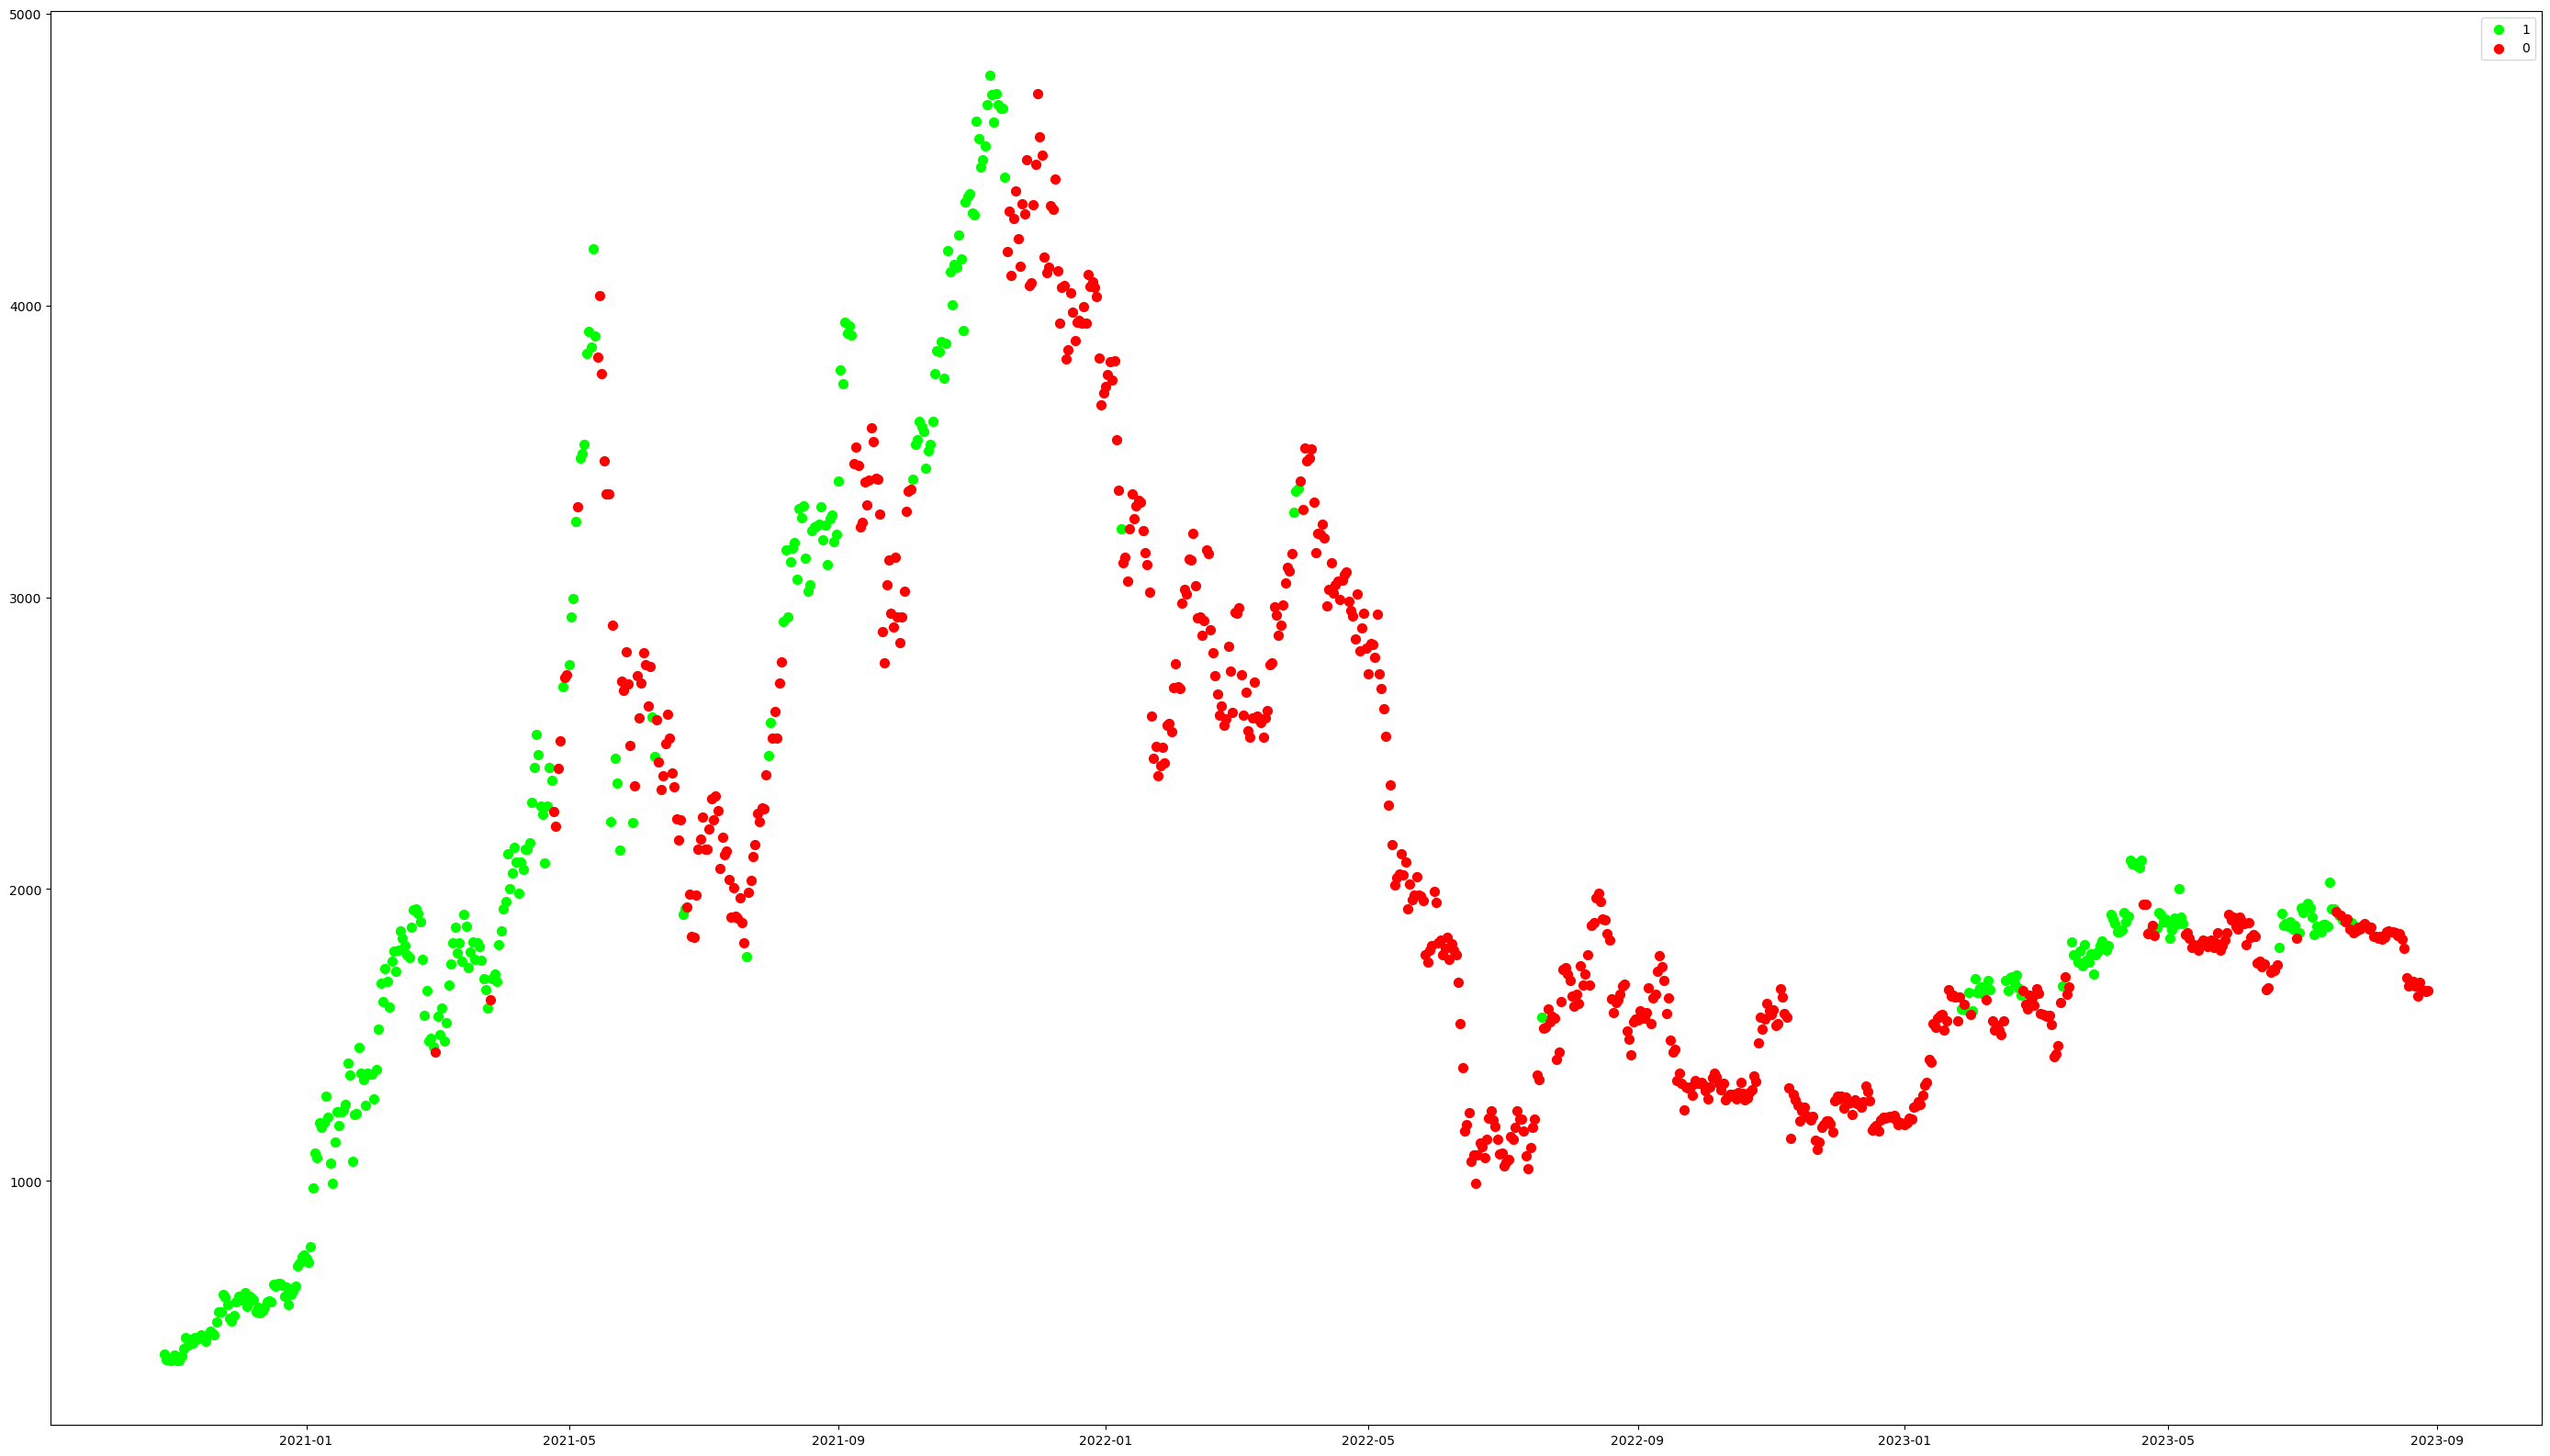

In [199]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_eda['signal'].unique(), ['lime','red']):
    mask = df_eda['signal'] == label
    ax.scatter(df_eda.index[mask], df_eda['close'][mask], label=label, c=color, s=50)
ax.legend()
plt.show()

In [200]:
# # Display the plot inline in Jupyter Lab
# %matplotlib inline

# # Plot the time series with clusters in different colors
# plot = df_encoded.hvplot.scatter(x='index', y='close',  c='cluster', legend='top_left', height=500, width=1000, title='Clusters of Time Series')

# # Show the plot in Jupyter notebook# plot

In [201]:
signals_df = df_eda.copy()

# change the first value of signal to first the algo to enter the market 
signals_df.loc['2020-10-28', 'signal'] = 0

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
signals_df['Entry/Exit'] = signals_df['signal'].diff()

# Review the DataFrame
signals_df.head(10)

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                                 
2020-10-28   21779.55712    -0.000003     False       True        False   
2020-10-29   19872.71065    -0.000003     False       True        False   
2020-10-30   42240.10139    -0.000003     False       True        False   
2020-10-31   20249.69114    -0.000003     False       True        False   
2020-11-01   30230.17745    -0.000003     False       True        False   
2020-11-02   76677.73386    -0.000003     False       True        False   
2020-11-03   27500.69202    -0.000003     False       True        False   
2020-11-04   45968.41064    -0.000003     False       True        False   
2020-11-05   36535.92210    -0.000003     False       True        False   
2020-11-06  110734.43539    -0.000003     False      False        False   

            fng_Hi_Greed  fng_Neutral  cluster   close  daily_returns  fng  \
timestamp                                                                    
2020-10-28         False        False        0  405.35       0.026930   70   
2020-10-29         False        False        0  388.17      -0.042383   67   
2020-10-30         False        False        0  390.74       0.006621   74   
2020-10-31         False        False        0  383.84      -0.017659   73   
2020-11-01         False        False        0  386.76       0.007607   72   
2020-11-02         False        False        0  402.45       0.040568   71   
2020-11-03         False        False        0  383.94      -0.045993   71   
2020-11-04         False        False        0  384.14       0.000521   74   
2020-11-05         False        False        0  401.57       0.045374   72   
2020-11-06          True        False        1  425.94       0.060687   90   

                fng_class  weekly_returns  signal  Entry/Exit  
timestamp                                                      
2020-10-28          Greed      112.236243       0         NaN  
2020-10-29          Greed       95.640341       1         1.0  
2020-10-30          Greed       92.758127       1         0.0  
2020-10-31          Greed       95.020831       1         0.0  
2020-11-01          Greed       91.550691       1         0.0  
2020-11-02          Greed       92.882818       1         0.0  
2020-11-03          Greed       81.026923       1         0.0  
2020-11-04          Greed       79.731437       1         0.0  
2020-11-05          Greed       89.876590       1         0.0  
2020-11-06  Extreme Greed      114.904137       1         0.0

In [202]:
# Visualize exit position relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# # Visualize moving averages
# moving_avgs = signals_df[['SMA50', 'SMA100']].hvplot(
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# Create the overlay plot
entry_exit_plot = security_close  * entry * exit #* moving_avgs

# Show the plot with a title
entry_exit_plot.opts(
    title="Apple - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

In [203]:
# Set initial capital
initial_capital = float(10000)

# Set the share size
share_size = 500

# Buy a 500 share position when the dual moving average crossover Signal equals 1
# Otherwise, `Position` should be zero (sell)
signals_df['Position'] = share_size * signals_df['signal']

# Determine the points in time where a 500 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()
# Multiply the close price by the number of shares held, or the Position
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']
# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum() 
# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']
# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()
# Calculate the portfolio cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1
# Print the DataFrame
signals_df.head(150)

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                                
2020-10-28  21779.55712    -0.000003     False       True        False   
2020-10-29  19872.71065    -0.000003     False       True        False   
2020-10-30  42240.10139    -0.000003     False       True        False   
2020-10-31  20249.69114    -0.000003     False       True        False   
2020-11-01  30230.17745    -0.000003     False       True        False   
...                 ...          ...       ...        ...          ...   
2021-03-22  25103.30095    -0.000003     False       True        False   
2021-03-23  32261.83479    -0.000003     False       True        False   
2021-03-24  33070.14699    -0.000003     False       True        False   
2021-03-25  29594.49507    -0.000003     False       True        False   
2021-03-26  31386.50933    -0.000003     False      False        False   

            fng_Hi_Greed  fng_Neutral  cluster    close  daily_returns  ...  \
timestamp                                                               ...   
2020-10-28         False        False        0   405.35       0.026930  ...   
2020-10-29         False        False        0   388.17      -0.042383  ...   
2020-10-30         False        False        0   390.74       0.006621  ...   
2020-10-31         False        False        0   383.84      -0.017659  ...   
2020-11-01         False        False        0   386.76       0.007607  ...   
...                  ...          ...      ...      ...            ...  ...   
2021-03-22         False        False        0  1757.44      -0.025955  ...   
2021-03-23         False        False        0  1692.53      -0.036934  ...   
2021-03-24         False        False        0  1654.13      -0.022688  ...   
2021-03-25         False        False        0  1591.48      -0.037875  ...   
2021-03-26         False         True        3  1620.51       0.018241  ...   

            weekly_returns signal  Entry/Exit  Position  Entry/Exit Position  \
timestamp                                                                      
2020-10-28      112.236243      0         NaN         0                  NaN   
2020-10-29       95.640341      1         1.0       500                500.0   
2020-10-30       92.758127      1         0.0       500                  0.0   
2020-10-31       95.020831      1         0.0       500                  0.0   
2020-11-01       91.550691      1         0.0       500                  0.0   
...                    ...    ...         ...       ...                  ...   
2021-03-22      396.297761      1         0.0       500                  0.0   
2021-03-23      380.341128      1         0.0       500                  0.0   
2021-03-24      387.656250      1         0.0       500                  0.0   
2021-03-25      368.275172      1         0.0       500                  0.0   
2021-03-26      364.050285      0        -1.0         0               -500.0   

            Portfolio Holdings  Portfolio Cash  Portfolio Total  \
timestamp                                                         
2020-10-28                 0.0             NaN              NaN   
2020-10-29            194085.0       -184085.0          10000.0   
2020-10-30            195370.0       -184085.0          11285.0   
2020-10-31            191920.0       -184085.0           7835.0   
2020-11-01            193380.0       -184085.0           9295.0   
...                        ...             ...              ...   
2021-03-22            878720.0       -245870.0         632850.0   
2021-03-23            846265.0       -245870.0         600395.0   
2021-03-24            827065.0       -245870.0         581195.0   
2021-03-25            795740.0       -245870.0         549870.0   
2021-03-26                 0.0        564385.0         564385.0   

            Portfolio Daily Returns  Portfolio Cumulative Returns  
timestamp                                    

In [204]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="ETHUSD Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [timestamp]   (Portfolio Total)

 Calculate and assign the following portfolio evaluation metrics to the portfolio evaluation DataFrame

In [205]:
# Create the list of the metric names
metrics = [
    'Annualized Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio'
]

# Create a list that holds the column name
columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and columns 
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the DataFrame
portfolio_evaluation_df

# Calculate the Annualized return metric
portfolio_evaluation_df.loc['Annualized Return'] = (
    signals_df['Portfolio Daily Returns'].mean() * 252
)
# Calculate the Cumulative returns metric
portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
# Calculate the Annual volatility metric
portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)
# Calculate the Sharpe ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals_df['Portfolio Daily Returns'].mean() * 252) / (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)
# Calculate the Sortino ratio
# Start by calculating the downside return values

# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,'Downside Returns'] = 0

# Find Portfolio Daily Returns values less than 0, 
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df['Portfolio Daily Returns'] < 0, 
                     'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2

# Calculate the annualized return value
annualized_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252

# Calculate the annualized downside standard deviation value
downside_standard_deviation = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)

# Divide the annualized return value by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
# Review the portfolio evaluation DataFrame
portfolio_evaluation_df

Backtest
Annualized Return   1.968895
Cumulative Returns   265.656
Annual Volatility   1.200972
Sharpe Ratio        1.639418
Sortino Ratio       3.826163

In [206]:
# Visualize the value of the total portfolio
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)


In [207]:

total_portfolio_value

:Curve   [timestamp]   (Portfolio Total)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
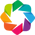

Loading BokehJS ...

In [208]:
from bokeh.plotting import show,output_notebook
import hvplot.pandas
import holoviews as hv

hv.extension('bokeh')

output_notebook()

show(hv.render(total_portfolio_value))

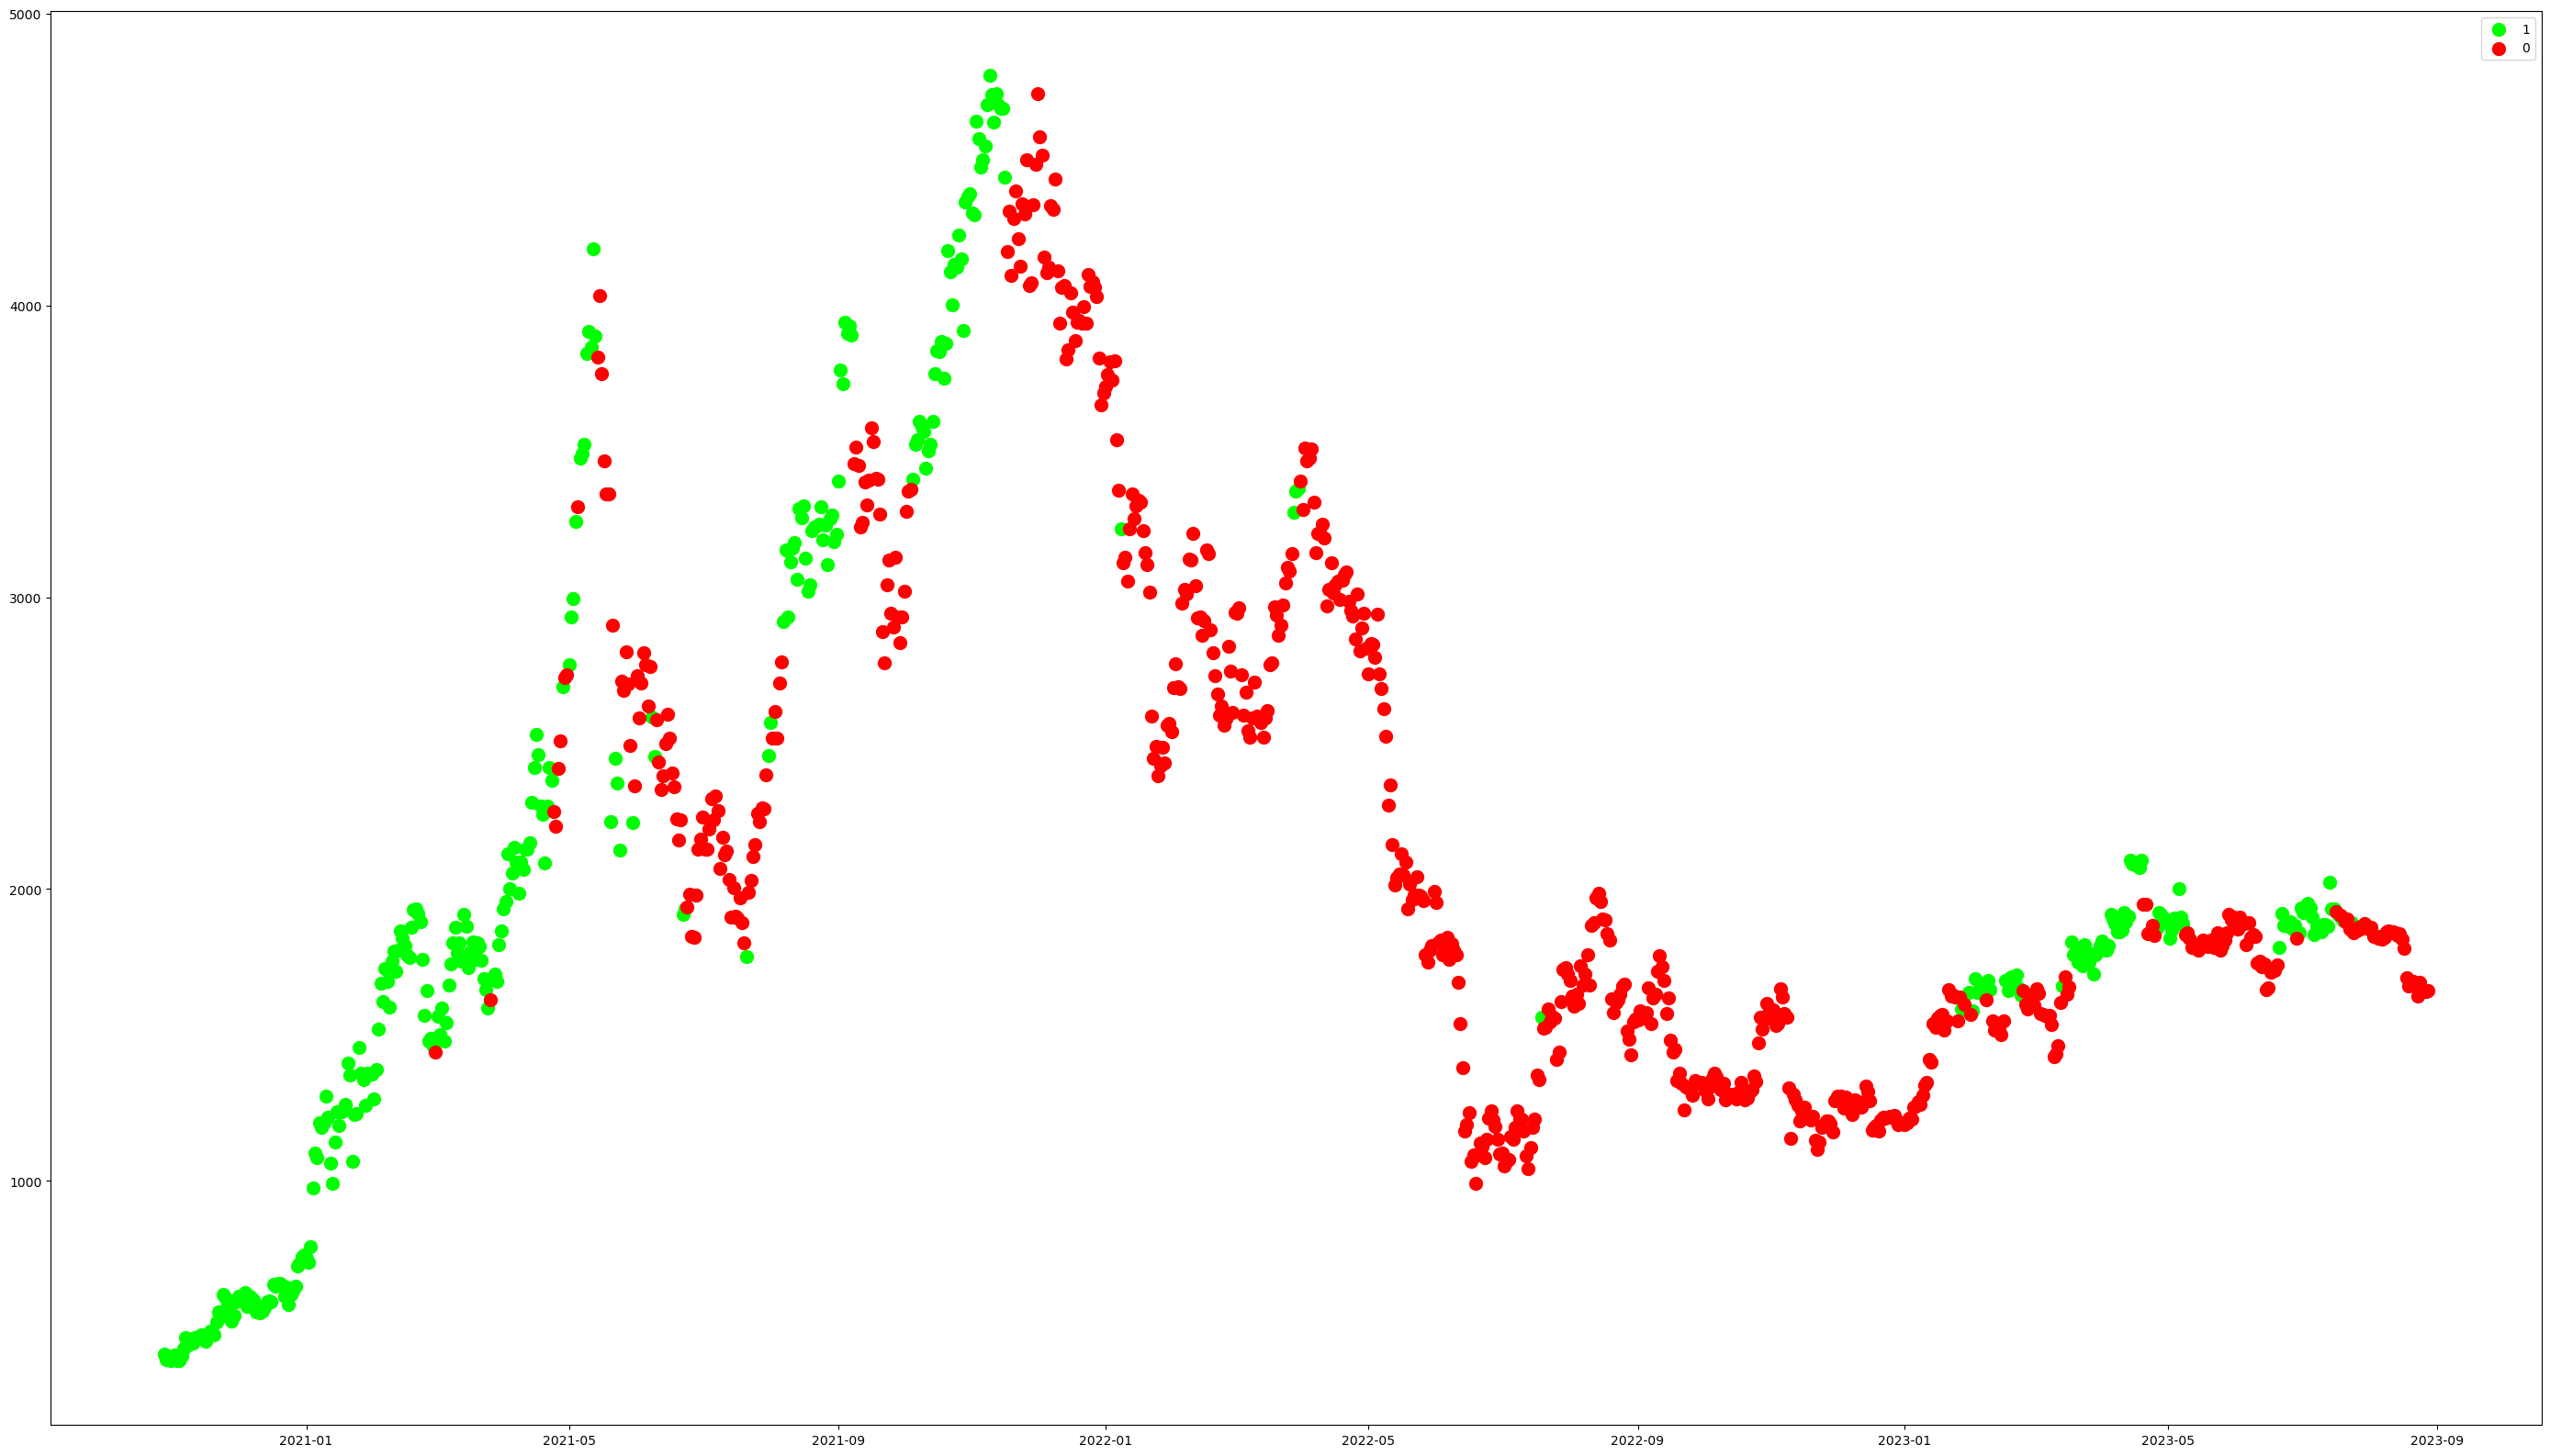

In [209]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_eda['signal'].unique(), ['lime','red']):
    mask = df_eda['signal'] == label
    ax.scatter(df_eda.index[mask], df_eda['close'][mask], label=label, c=color, s=100)
ax.legend()
plt.show()

In [210]:
df_eda.head()

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                                
2020-10-28  21779.55712    -0.000003     False       True        False   
2020-10-29  19872.71065    -0.000003     False       True        False   
2020-10-30  42240.10139    -0.000003     False       True        False   
2020-10-31  20249.69114    -0.000003     False       True        False   
2020-11-01  30230.17745    -0.000003     False       True        False   

            fng_Hi_Greed  fng_Neutral  cluster   close  daily_returns  fng  \
timestamp                                                                    
2020-10-28         False        False        0  405.35       0.026930   70   
2020-10-29         False        False        0  388.17      -0.042383   67   
2020-10-30         False        False        0  390.74       0.006621   74   
2020-10-31         False        False        0  383.84      -0.017659   73   
2020-11-01         False        False        0  386.76       0.007607   72   

           fng_class  weekly_returns  signal  
timestamp                                     
2020-10-28     Greed      112.236243       1  
2020-10-29     Greed       95.640341       1  
2020-10-30     Greed       92.758127       1  
2020-10-31     Greed       95.020831       1  
2020-11-01     Greed       91.550691       1

In [211]:
df_eda.tail()

volume  price_slope  fng_Fear  fng_Greed  fng_Hi_Fear  \
timestamp                                                               
2023-08-24   4994.1263    -0.000003      True      False        False   
2023-08-25   5725.3494    -0.000003      True      False        False   
2023-08-26   2200.4796    -0.000003      True      False        False   
2023-08-27   2138.1652    -0.000003      True      False        False   
2023-08-28  10892.1113    -0.000003      True      False        False   

            fng_Hi_Greed  fng_Neutral  cluster    close  daily_returns  fng  \
timestamp                                                                     
2023-08-24         False        False        2  1681.98       0.029918   41   
2023-08-25         False        False        2  1656.14      -0.015363   39   
2023-08-26         False        False        2  1652.08      -0.002451   38   
2023-08-27         False        False        2  1647.92      -0.002518   38   
2023-08-28         False        False        2  1651.62       0.002245   39   

           fng_class  weekly_returns  signal  
timestamp                                     
2023-08-24      Fear        9.514601       0  
2023-08-25      Fear       16.146995       0  
2023-08-26      Fear       15.081814       0  
2023-08-27      Fear       12.567455       0  
2023-08-28      Fear        2.465444       0

---
## 2ND Feat Engineering

In [212]:
import finta as ft
from finta import TA
import talib

prep_df = df_eng.copy()
prep_df['signal'] = df_eda['signal']


In [213]:
prep_df.columns

Index(['fng', 'fng_class', 'open', 'high', 'low', 'close', 'volume',
       'daily_returns', 'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA',
       'Trolololo', 'MVRV', 'ReserveRisk', 'Woobull', 'Confidence',
       'CBBI_class', 'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100',
       'ADX_100', 'RSI_100', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200',
       'ATR_200', 'ADX_200', 'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300',
       'VAMA_300', 'ATR_300', 'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500',
       'HMA_500', 'VAMA_500', 'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750',
       'EMA_750', 'HMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000',
       'EMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000', 'EMA_1500', 'RSI_1500',
       'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci',
       'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b',
       'weekly_returns', 'price_slope', 'signal'],
      dtype='object')

In [214]:
# Dummy-encoding process 
# create a list of categorical columns
cat_cols = ['fng_class']

# use the get_dummies function to dummy encode the categorical columns
dummy_cols = pd.get_dummies(prep_df[cat_cols], prefix=cat_cols, drop_first=True)

# concatenate the dummy columns with the original dataframe
prep_df = pd.concat([prep_df.drop(cat_cols, axis=1), dummy_cols], axis=1)

In [215]:
prep_df['signal'].value_counts()

signal
0    659
1    376
Name: count, dtype: int64

___
### 3.5 Class Imbalance

In [216]:
import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = prep_df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = prep_df[prep_df['signal'] != minority_class]
minority_class = prep_df[prep_df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [217]:
balanced_df["signal"].value_counts()

signal
1    376
0    376
Name: count, dtype: int64

In [218]:
balanced_df.columns

Index(['fng', 'open', 'high', 'low', 'close', 'volume', 'daily_returns',
       'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA', 'Trolololo',
       'MVRV', 'ReserveRisk', 'Woobull', 'Confidence', 'CBBI_class', 'SMA_100',
       'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100', 'ADX_100', 'RSI_100',
       'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200',
       'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300', 'VAMA_300', 'ATR_300',
       'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500', 'HMA_500', 'VAMA_500',
       'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750', 'EMA_750', 'HMA_750',
       'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000', 'EMA_1000', 'ATR_1000',
       'ADX_1000', 'RSI_1000', 'EMA_1500', 'RSI_1500', 'UO', 'AO', 'OBV',
       'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen',
       'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'weekly_returns',
       'price_slope', 'signal', 'fng_class_Extreme Greed', 'fng_class_Fear',
       'fng_class_Greed', 'fng_c

In [219]:
# Creating X as predictors (features) dataset
X= balanced_df.copy()

# sort X by index
X = X.sort_index(axis=0)

# Removing columns indicative of previous prices
# & shifting X one row down to avoid using data not available to us at the time of prediction
X= X.drop(["open","high","low","close","volume","Price",
           "CBBI_class",
           "fng_class_Extreme Greed", "fng_class_Fear", "fng_class_Greed",
           "fng_class_Neutral",
           "daily_returns",#"weekly_returns",
           "signal"], axis =1).shift().dropna().copy()

In [220]:
X.columns

Index(['fng', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA', 'Trolololo', 'MVRV',
       'ReserveRisk', 'Woobull', 'Confidence', 'SMA_100', 'EMA_100', 'HMA_100',
       'VAMA_100', 'ATR_100', 'ADX_100', 'RSI_100', 'SMA_200', 'EMA_200',
       'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200', 'RSI_200', 'SMA_300',
       'EMA_300', 'HMA_300', 'VAMA_300', 'ATR_300', 'ADX_300', 'RSI_300',
       'SMA_500', 'EMA_500', 'HMA_500', 'VAMA_500', 'ATR_500', 'ADX_500',
       'RSI_500', 'SMA_750', 'EMA_750', 'HMA_750', 'ATR_750', 'ADX_750',
       'RSI_750', 'SMA_1000', 'EMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000',
       'EMA_1500', 'RSI_1500', 'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER',
       'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen', 'kijun_sen', 'senkou_span_a',
       'senkou_span_b', 'weekly_returns', 'price_slope'],
      dtype='object')

In [221]:
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = X.corr()

# set the threshold for correlation value
corr_threshold = 0.60

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
X.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = X.columns.tolist()

# print the low correlated features
print(low_corr_features)

['fng', 'PiCycle', 'SMA_100', 'UO', 'CHAIKIN', 'price_slope']


In [222]:
X = X[low_corr_features]

In [223]:
X

fng  PiCycle    SMA_100         UO       CHAIKIN  price_slope
timestamp                                                                 
2020-10-29  70.0   0.5633   371.7733  65.970817  36094.013639    -0.000003
2020-10-30  67.0   0.5649   373.2883  51.629646  29578.495996    -0.000003
2020-10-31  74.0   0.5666   374.7536  49.350265  34914.669956    -0.000003
2020-11-01  73.0   0.5682   375.9488  50.583285  38191.792330    -0.000003
2020-11-02  72.0   0.5699   377.0772  48.164142  33289.504248    -0.000003
...          ...      ...        ...        ...           ...          ...
2023-08-21  37.0   0.5649  1843.6573  27.678147  19167.714481    -0.000003
2023-08-24  38.0   0.5638  1842.3981  29.388313  18433.899318    -0.000003
2023-08-25  41.0   0.5595  1838.1787  33.452711   5865.687322    -0.000003
2023-08-27  39.0   0.5579  1836.4858  37.150150   2370.900597    -0.000003
2023-08-28  38.0   0.5555  1833.2374  36.551181   -590.699901    -0.000003

[751 rows x 6 columns]

In [224]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"].copy()

# keeping y and X the same size 
y = y[X.index]

In [225]:
y

timestamp
2020-10-29    1
2020-10-30    1
2020-10-31    1
2020-11-01    1
2020-11-02    1
             ..
2023-08-21    0
2023-08-24    0
2023-08-25    0
2023-08-27    0
2023-08-28    0
Name: signal, Length: 751, dtype: int64

---
## ML Scaler

In [226]:
from sklearn.preprocessing import StandardScaler

# Scale the data
MLscaler = StandardScaler()
X_scaled = MLscaler.fit_transform(X)

# Convert the scaled numpy array back to a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [227]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the data
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create a logistic regression model
model = LogisticRegression(max_iter=200)

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=25)

# Fit the RFE model to the data
rfe = rfe.fit(X_scaled, y)

# Get the selected features
selected_features = X_scaled.columns[rfe.support_]

# Keep only specified columns in the dataframe
X_scaled = X_scaled[selected_features]

# Print the selected features
print("Number of selected features:", len(X_scaled.columns), "\nSelected features:\n", selected_features)


Number of selected features: 6 
Selected features:
 Index(['fng', 'PiCycle', 'SMA_100', 'UO', 'CHAIKIN', 'price_slope'], dtype='object')


In [228]:
df_lo_feats = X[selected_features].copy()
#df_lo_feats = df_lo_feats.drop(["fng_value"], axis =1)
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_lo_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.90

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_lo_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_lo_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['fng', 'PiCycle', 'SMA_100', 'UO', 'CHAIKIN', 'price_slope']


In [229]:
X=df_lo_feats[low_corr_features]
#X = X[selected_features]

In [230]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=36)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

fng  PiCycle   SMA_100         UO       CHAIKIN  price_slope
timestamp                                                                
2020-10-29  70.0   0.5633  371.7733  65.970817  36094.013639    -0.000003
2020-10-30  67.0   0.5649  373.2883  51.629646  29578.495996    -0.000003
2020-10-31  74.0   0.5666  374.7536  49.350265  34914.669956    -0.000003
2020-11-01  73.0   0.5682  375.9488  50.583285  38191.792330    -0.000003
2020-11-02  72.0   0.5699  377.0772  48.164142  33289.504248    -0.000003

Empty DataFrame
Columns: [fng, PiCycle, SMA_100, UO, CHAIKIN, price_slope]
Index: []

In [231]:
## Scaler for ML pre-processing

In [232]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by StandardScaler.

---
## 4. ML models 
#### 4.1 XGboost

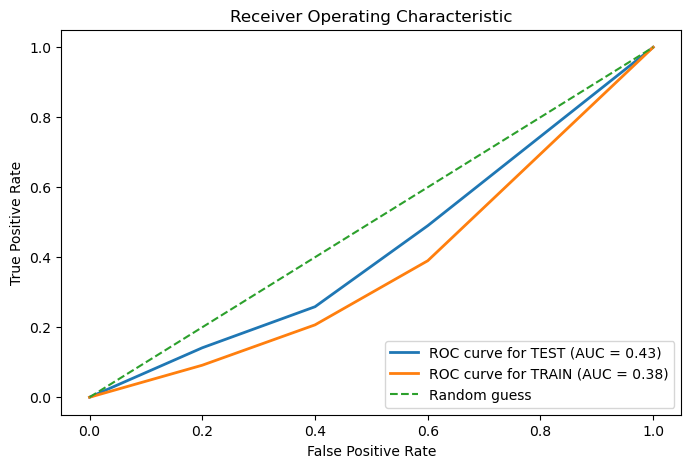

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.18      0.08      0.11      8697
           1       0.48      0.71      0.57     10360

    accuracy                           0.42     19057
   macro avg       0.33      0.39      0.34     19057
weighted avg       0.34      0.42      0.36     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.43      0.17      0.25      6970
           1       0.39      0.70      0.50      5309

    accuracy                           0.40     12279
   macro avg       0.41      0.44      0.37     12279
weighted avg       0.41      0.40      0.36     12279

Test accuracy: 0.40
>> Test precision: 0.40 <<
Test recall: 0.40
Test F1 score: 0.40
Test AUC score: 0.43


In [ ]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=10)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

<Axes: >

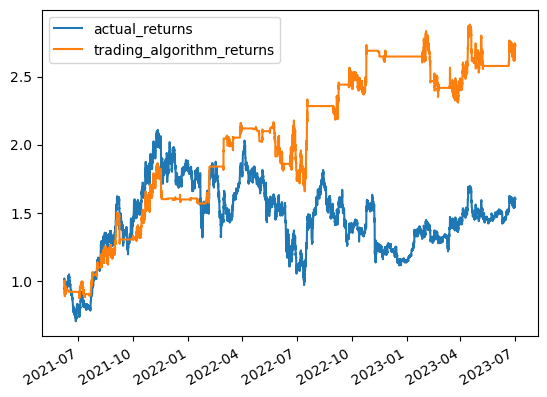

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = xgb_clf

# Backtest using our exteranl function
xgb_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

> The XGB results appear to be too good to be true - the classification report are very weird as well --> not to use for production

In [ ]:
X_test.columns


Index(['fng', 'PiCycle', 'SMA_100', 'ADX_100', 'RSI_100', 'UO', 'AO',
       'price_slope'],
      dtype='object')

---
#### 4.2 CatBoost

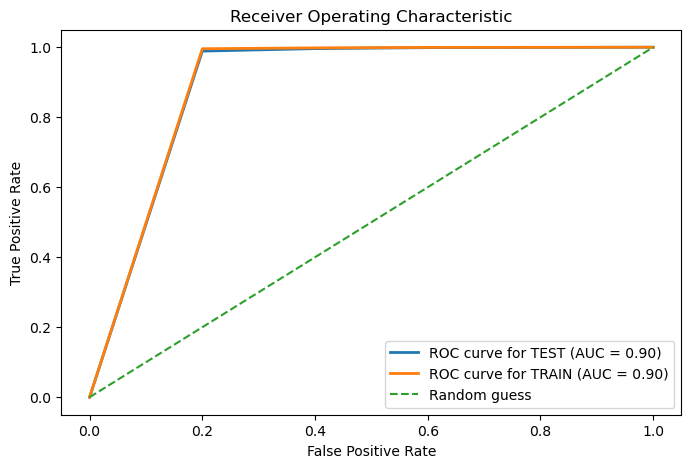

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      8697
           1       0.95      0.96      0.96     10360

    accuracy                           0.95     19057
   macro avg       0.95      0.95      0.95     19057
weighted avg       0.95      0.95      0.95     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      6970
           1       0.93      0.93      0.93      5309

    accuracy                           0.94     12279
   macro avg       0.93      0.93      0.93     12279
weighted avg       0.94      0.94      0.94     12279

Test accuracy: 0.94
>> Test precision: 0.94 <<
Test recall: 0.94
Test F1 score: 0.94
Test AUC score: 0.90


In [ ]:
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=.001,
    depth=5,
    l2_leaf_reg=.001,  # L2 regularization parameter
    verbose=False
)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

# display ROC and classification metrics 
ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

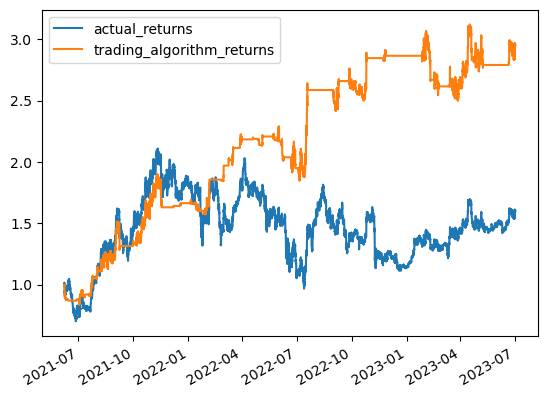

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = cb_clf

# Backtest using our exteranl function
cb_predictions_df = Backtesting (df_eda, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + cb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
#### 4.3 LDA

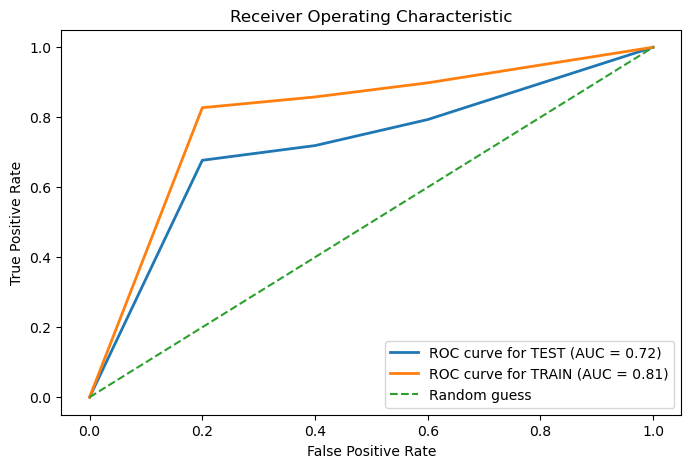

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      8697
           1       0.84      0.82      0.83     10360

    accuracy                           0.82     19057
   macro avg       0.82      0.82      0.82     19057
weighted avg       0.82      0.82      0.82     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.71      0.35      0.47      6970
           1       0.49      0.82      0.61      5309

    accuracy                           0.55     12279
   macro avg       0.60      0.58      0.54     12279
weighted avg       0.62      0.55      0.53     12279

Test accuracy: 0.55
>> Test precision: 0.55 <<
Test recall: 0.55
Test F1 score: 0.55
Test AUC score: 0.72


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create LDA object and fit the model
lda = LinearDiscriminantAnalysis()

# Train the model on the training data
lda.fit_transform(X_train_scaled, y_train)

ROC(lda,X_train_scaled, X_test_scaled, y_train, y_test)

<Axes: >

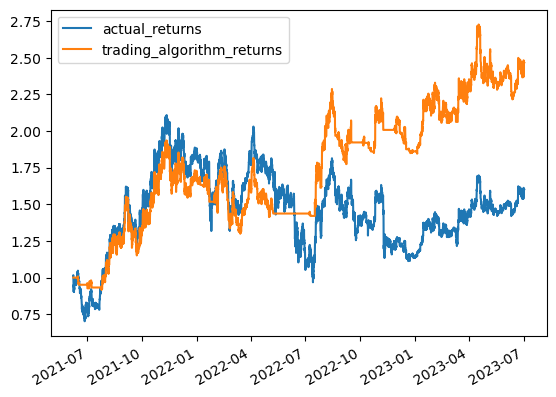

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lda

# Backtest using our exteranl function
lda_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lda_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

## 4.4 Gradient Boosting Tree Classifier

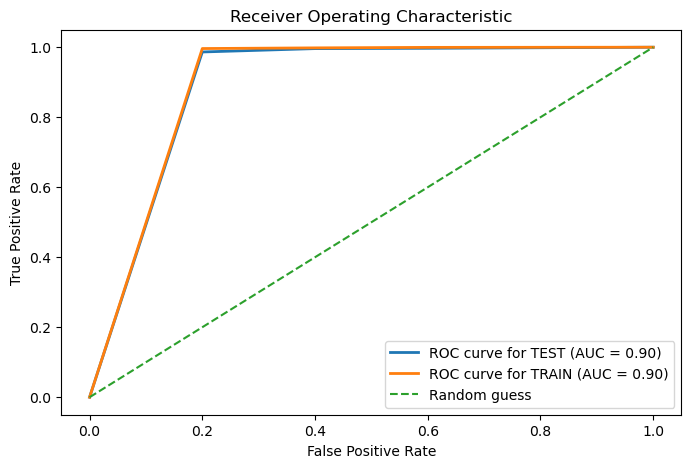

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      8697
           1       0.95      0.97      0.96     10360

    accuracy                           0.95     19057
   macro avg       0.95      0.95      0.95     19057
weighted avg       0.95      0.95      0.95     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      6970
           1       0.91      0.94      0.93      5309

    accuracy                           0.93     12279
   macro avg       0.93      0.94      0.93     12279
weighted avg       0.94      0.93      0.94     12279

Test accuracy: 0.93
>> Test precision: 0.93 <<
Test recall: 0.93
Test F1 score: 0.93
Test AUC score: 0.90


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model with regularization
gbt_clf = GradientBoostingClassifier(
    learning_rate = .01, 
    subsample = .1, 
    max_depth=3, 
    #min_samples_split=10, 
    #min_samples_leaf=10, 
    #max_leaf_nodes=None, 
    random_state=seed
    )

# Train the model on the training data
gbt_clf.fit(X_train_scaled, y_train)

ROC(gbt_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

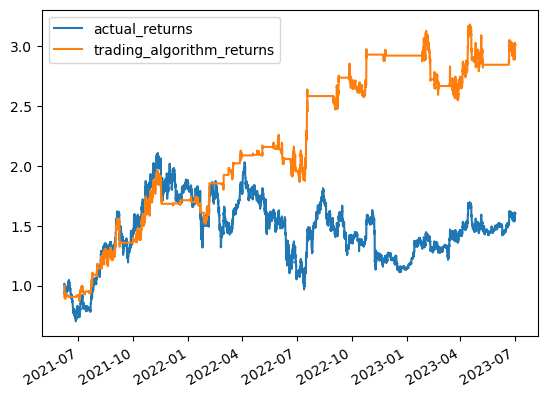

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = gbt_clf

# Backtest using our exteranl function
gbt_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + gbt_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
display (df_eda.head())
display (gbt_predictions_df.head())

volume   ADX_100  fng_Fear  fng_Greed  fng_Hi_Fear  \
2018-06-07 07:00:00  2097.03849  7.922152      True      False        False   
2018-06-07 08:00:00  4142.71778  7.906581      True      False        False   
2018-06-07 09:00:00  2678.96166  7.884788      True      False        False   
2018-06-07 10:00:00  1989.56528  7.863214      True      False        False   
2018-06-07 11:00:00  1659.15096  7.841855      True      False        False   

                     fng_Hi_Greed  fng_Neutral  cluster   close  \
2018-06-07 07:00:00         False        False        0  609.58   
2018-06-07 08:00:00         False        False        0  608.18   
2018-06-07 09:00:00         False        False        0  609.64   
2018-06-07 10:00:00         False        False        0  607.99   
2018-06-07 11:00:00         False        False        0  607.60   

                     daily_returns  ...  fng_class weekly_returns  signal  \
2018-06-07 07:00:00       0.003738  ...       Fear       6.419232       0   
2018-06-07 08:00:00      -0.002297  ...       Fear       6.561772       0   
2018-06-07 09:00:00       0.002401  ...       Fear       6.606512       0   
2018-06-07 10:00:00      -0.002707  ...       Fear       6.414744       0   
2018-06-07 11:00:00      -0.000641  ...       Fear       5.682431       0   

                     Position  Entry/Exit Position  Portfolio Holdings  \
2018-06-07 07:00:00         0                  NaN                 0.0   
2018-06-07 08:00:00         0                  0.0                 0.0   
2018-06-07 09:00:00         0                  0.0                 0.0   
2018-06-07 10:00:00         0                  0.0                 0.0   
2018-06-07 11:00:00         0                  0.0                 0.0   

                     Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
2018-06-07 07:00:00             NaN              NaN                      NaN   
2018-06-07 08:00:00         10000.0          10000.0                      NaN   
2018-06-07 09:00:00         10000.0          10000.0                      0.0   
2018-06-07 10:00:00         10000.0          10000.0                      0.0   
2018-06-07 11:00:00         10000.0          10000.0                      0.0   

                     Portfolio Cumulative Returns  
2018-06-07 07:00:00                           NaN  
2018-06-07 08:00:00                           NaN  
2018-06-07 09:00:00                           0.0  
2018-06-07 10:00:00                           0.0  
2018-06-07 11:00:00                           0.0  

[5 rows x 21 columns]

predicted_signal  actual_returns  \
2021-06-07 10:00:00                 1        0.014616   
2021-06-07 11:00:00                 1       -0.004749   
2021-06-07 12:00:00                 1        0.006513   
2021-06-07 13:00:00                 1       -0.014794   
2021-06-07 14:00:00                 1       -0.004249   

                     trading_algorithm_returns  
2021-06-07 10:00:00                        NaN  
2021-06-07 11:00:00                  -0.004749  
2021-06-07 12:00:00                   0.006513  
2021-06-07 13:00:00                  -0.014794  
2021-06-07 14:00:00                  -0.004249

In [ ]:
display(len(df_eda),len(gbt_predictions_df))

44225

12279

In [ ]:
df = gbt_predictions_df

In [ ]:
df['close'] = df_eda['close']

In [ ]:
# Rename column 'predicted_signal' to 'gbt_prediction'
df = df.rename(columns={'predicted_signal': 'gbt_prediction'})

In [ ]:
df.head()

gbt_prediction  actual_returns  \
2021-06-07 10:00:00               1        0.014616   
2021-06-07 11:00:00               1       -0.004749   
2021-06-07 12:00:00               1        0.006513   
2021-06-07 13:00:00               1       -0.014794   
2021-06-07 14:00:00               1       -0.004249   

                     trading_algorithm_returns    close  
2021-06-07 10:00:00                        NaN  2826.07  
2021-06-07 11:00:00                  -0.004749  2812.65  
2021-06-07 12:00:00                   0.006513  2830.97  
2021-06-07 13:00:00                  -0.014794  2789.09  
2021-06-07 14:00:00                  -0.004249  2777.24

In [ ]:
import pandas as pd
import numpy as np
import hvplot.pandas

# init
initial_capital = 10000
duration_dca_buy = 10
duration_dca_sell = 3
fee = 0.75/100 # 0.75% fee Kucoin

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0
df['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df.loc[df.index[i - 1], 'dca_eth_owned']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount * (1-fee)/ df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount * (1-fee) / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount 

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df.loc[df.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df.loc[df.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df.loc[df.index[i], 'dca_eth_owned'] = dca_eth_owned
        df.loc[df.index[i], 'dca_value'] = dca_eth_owned * df.loc[df.index[i], 'close']




In [ ]:

# Plot the results
plot = df[['algo_value','dca_value']].hvplot.line(title='Algo-Trading with DCA_Strategy vs. DCA-ETH', width=1000, height=400)
plot


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
plot = (1 + gbt_predictions_df[["trading_algorithm_returns", "actual_returns"]]).cumprod().hvplot.line(title='ETH HODL returns vs Algo-Trading w/o DCA',width=1100, height=400)
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
import pandas as pd
import numpy as np
import hvplot.pandas

# init
initial_capital = 10000
duration_dca_buy = 10
duration_dca_sell = 3
fee = 0.75/100 # 0.75% fee Kucoin

df_noML = gbt_predictions_df.copy()
df_noML ['signal'] = prep_df['signal'].shift()

# Add new columns to store calculations
df_noML['eth_owned'] = 0.0
df_noML['current_usd_capital'] = initial_capital
df_noML['algo_value'] = 0.0
df_noML['dca_value'] = 0.0
df_noML['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df_noML.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df_noML.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df_noML.loc[df_noML.index[i - 1], 'dca_eth_owned']
    
    if df_noML.loc[df_noML.index[i], 'signal'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df_noML.loc[df_noML.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount * (1-fee)/ df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df_noML.loc[df_noML.index[i], 'close']) / duration_dca_sell
        
    elif df_noML.loc[df_noML.index[i], 'signal'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df_noML.loc[df_noML.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount * (1-fee) / df_noML.loc[df_noML.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount 

    df_noML.loc[df_noML.index[i], 'eth_owned'] = eth_owned
    df_noML.loc[df_noML.index[i], 'current_usd_capital'] = current_usd_capital
    df_noML.loc[df_noML.index[i], 'algo_value'] = eth_owned * df_noML.loc[df_noML.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df_noML.loc[df_noML.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df_noML.loc[df_noML.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df_noML.loc[df_noML.index[i], 'dca_eth_owned'] = dca_eth_owned
        df_noML.loc[df_noML.index[i], 'dca_value'] = dca_eth_owned * df_noML.loc[df_noML.index[i], 'close']




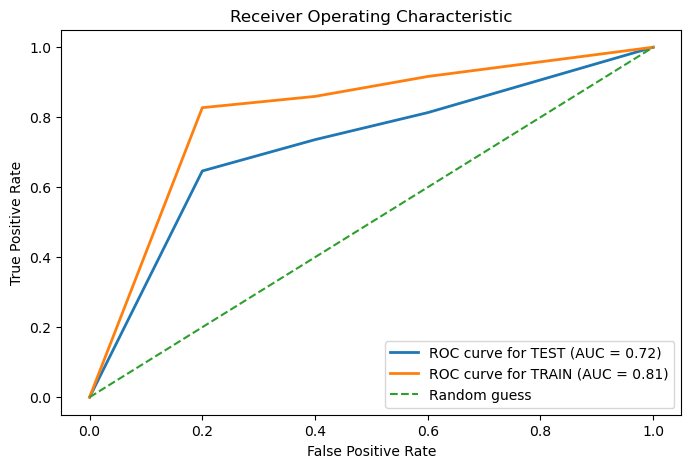

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      8697
           1       0.83      0.83      0.83     10360

    accuracy                           0.81     19057
   macro avg       0.81      0.81      0.81     19057
weighted avg       0.81      0.81      0.81     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.79      0.31      0.45      6970
           1       0.50      0.89      0.64      5309

    accuracy                           0.56     12279
   macro avg       0.64      0.60      0.54     12279
weighted avg       0.66      0.56      0.53     12279

Test accuracy: 0.56
>> Test precision: 0.56 <<
Test recall: 0.56
Test F1 score: 0.56
Test AUC score: 0.72


In [ ]:
# create the logistic regression model
lr_model = LogisticRegression()

# fit the model on the training data
lr_model.fit(X_train_scaled, y_train)

# display ROC curve and classification results
ROC(lr_model,X_train_scaled,X_test_scaled,y_train,y_test)

<Axes: >

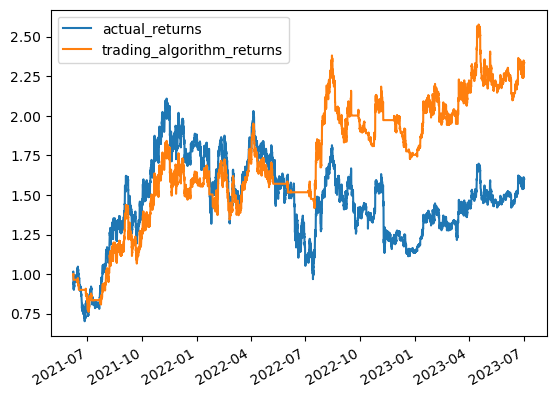

In [ ]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lr_model

# Backtest using our exteranl function
lr_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
## Adding Short and Long strategy 

<Axes: >

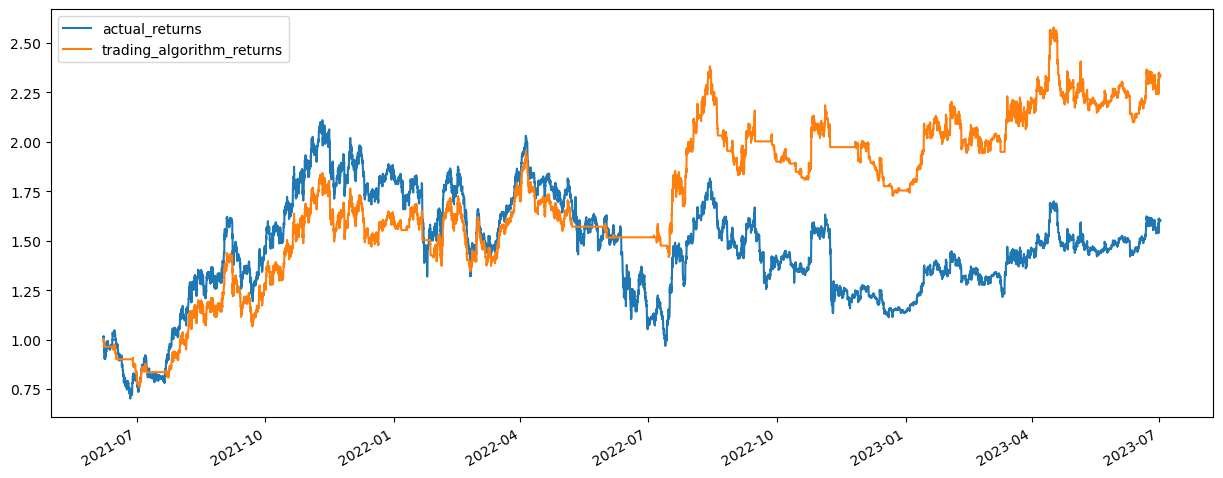

In [ ]:
lr_predictions_df['futures_predicted'] = lr_predictions_df['trading_algorithm_returns'].replace(0,-1)
lr_predictions_df['Strategy_Returns'] = lr_predictions_df["actual_returns"] * lr_predictions_df["futures_predicted"]

# Plot the actual returns versus the strategy returns
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(figsize=(15,6))

---
## 5 Model Building helpers

These utilities below are helpful for identifying the best models and understanding them better. However, they may take a long time to run. If needed, you can interrupt their execution as they are not essential for the machine learning process.

### Selecting best performing model 

In [ ]:
model_selection(X_test_scaled,y_test)

Model Name  F1_Mean  F1_Standard Deviation
0  LinearDiscriminantAnalysis     0.72                  0.015
1        KNeighborsClassifier     0.93                  0.008
2      DecisionTreeClassifier     0.96                  0.006
3      RandomForestClassifier     0.97                  0.006
4        ExtraTreesClassifier     0.97                  0.004
5          AdaBoostClassifier     0.96                  0.005
6                         SVM     0.86                  0.013
7  GradientBoostingClassifier     0.96                  0.006
8                     XGBoost     0.97                  0.005

### SHAP Analysis 

In [ ]:
# Resample X_test
upscaled_X_test = X_test.resample('1D').interpolate(method='linear')


In [ ]:
# define which classifier to use 
clf = xgb_clf


# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# SHAP Analysis 
# define which classifier to use 
clf = cb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")